# $\epsilon$-greedy Bandit

In [1]:
# Import modules.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
%matplotlib inline
import import_ipynb
from abstract_bandit import Bandit

importing Jupyter notebook from abstract_bandit.ipynb


In [2]:
class EpsBandit(Bandit):

    def __init__(self, means, sigmas, init_est, arms=10, iters=10000, eps=0.0, alpha=None, deterministic=False, stationary=True):
        """Initializes the Epsilon-greedy bandit."""
        super().__init__(means, sigmas, arms=arms, iters=iters, deterministic=deterministic, stationary=stationary)
        # Degree of exploration.
        self.eps = eps
        # Step size for update.
        self.alpha = alpha
        # Estimates of means.
        self.est_means = np.full(arms, init_est)
        # Matrix to store the trend of the estimated means.
        self.Qs = np.zeros((iters + 1, arms))
        self.Qs[0, :] = self.est_means

    def choose_action(self):
        """Implements the epsilon-greedy policy: exploits knowledge or explores new possibilities."""
        choice = np.random.choice([0, 1], p=[1.0 - self.eps, self.eps])
        if choice == 0:
            # Greedy choice.
            return np.argmax(self.est_means)
        else:
            # Explorative choice.
            return np.random.choice(list(range(self.arms)))

    def update_model(self, arm, reward, iteration):
        """Updates estimates and other data after an episode."""
        # Update choice count.
        self.Ns[arm] += 1
        # Update step size.
        if self.alpha == None:
            step_size = 1.0 / float(self.Ns[arm])
        else:
            step_size = self.alpha
        # Update reward estimate.
        self.est_means[arm] = self.est_means[arm] + step_size * (reward - self.est_means[arm])
        # Decrease exploration probability.
        if (self.stationary == True) and (self.eps >= ((self.eps / float(self.iters)) * float(iteration + 1))):
            self.eps -= (self.eps / float(self.iters)) * float(iteration + 1)
        # Eventually increase optimal actions counter.
        if arm == np.argmax(self.means):
            self.opt_actions += 1.0
        # Update real action values.
        if self.stationary == False:
            for i in range(self.arms):
                self.means[i] += self.means_rng.standard_normal()

    def update_sim_data(self, arm , reward, iteration):
        """Updates simulation data after an episode."""
        self.avg_rewards[iteration + 1] = self.avg_rewards[iteration] + (1.0 / float(iteration + 1)) * (reward - self.avg_rewards[iteration]) 
        self.Qs[iteration + 1, :] = self.Qs[iteration, :]
        self.Qs[iteration + 1, arm] = self.est_means[arm]
        self.qs[iteration + 1, :] = self.means

def eps_plots(iters, opt_init, arms, means, sigmas, alphas, epsilons, det, stat):
    """Function that generates test plots for this Bandit."""
    # Simulation data arrays.
    rews = np.zeros((len(alphas), len(epsilons), iters + 1))
    actions = np.zeros((len(alphas), len(epsilons), arms))
    optimals = np.zeros((len(alphas), len(epsilons)))
    Qs_list = []
    qs_list = []

    # Bandits execution.
    for i in range(len(alphas)):
        Qs_temp = []
        qs_temp = []
        for j in range(len(epsilons)):
            bandit = EpsBandit(np.copy(means), sigmas, opt_init, arms=arms, iters=iters, alpha=alphas[i], eps=epsilons[j], deterministic=det, stationary=stat)
            bandit.run()
            rews[i, j, :] = bandit.get_avg_rewards()
            actions[i, j, :] = bandit.get_actions()
            optimals[i, j] = bandit.get_opt_actions()
            qs_values = bandit.get_real_means()
            Qs_temp.append(bandit.get_est_means())
            qs_temp.append(bandit.get_real_means())
        Qs_list.append(Qs_temp)
        qs_list.append(qs_temp)
            
    colors = cm.brg(np.linspace(0, 1, len(epsilons)))
    for i in range(len(alphas)):
        fig = plt.figure(figsize=(20,40))
        plt.subplots_adjust(top=0.95)
        fig.suptitle(r'$\alpha$ = ' + str(alphas[i]))
        gs = gridspec.GridSpec(1+arms, 2, figure=fig)
        # Average rewards plot.
        ax1 = plt.subplot(gs[0, 0])
        for j in range(len(epsilons)):
            ax1.plot(rews[i, j, :], color=colors[j], label=r'$\epsilon$ = ' + str(epsilons[j]))
        ax1.legend(loc='upper right')
        ax1.set(xlabel='Iterations', ylabel='Avg. rewards')
        ax1.set_title('Average rewards')
        # Actions taken plot
        ax2 = plt.subplot(gs[0, 1])
        x = np.arange(arms)
        width = 1
        pos = list(range(1 - len(epsilons), len(epsilons), 2))
        for j in range(len(epsilons)):
            ax2.bar(x * width + pos[j] / (2.0 * len(epsilons)), actions[i, j, :], width / len(epsilons), color=colors[j], label=r'$\epsilon$ = ' + str(epsilons[j]))
        ax2.legend(loc='upper right')
        ax2.set_yscale('log')
        ax2.set_xticks(x)
        ax2.set_xticklabels(np.arange(1, arms+1))
        ax2.set(xlabel='Actions', ylabel='Number of actions taken')
        ax2.set_title('Actions taken')
        # Real mean vs estimated means subplots
        for k in range(arms):
            ax = plt.subplot(gs[k+1, :])
            ax.set_title("Arm " + str(k+1))
            for j in range(len(epsilons)):
                Qs_current = Qs_list[i][j]
                qs_current = qs_list[i][j]
                ax.plot(Qs_current[:, k], color=colors[j], label=r'$\epsilon$ = ' + str(epsilons[j]))
                ax.plot(qs_current[:, k], color='k')
            ax.legend(loc='upper right')

    # Optimal actions frequency heatmap.
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(optimals, cmap='Blues')
    ax.set_xticks(np.arange(len(epsilons)))
    ax.set_yticks(np.arange(len(alphas)))
    ax.set_xticklabels(map(str, epsilons))
    ax.set_yticklabels(map(str, alphas))
    ax.set_title("Percentages of optimal actions taken")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(alphas)):
        for j in range(len(epsilons)):
            text = ax.text(j, i, optimals[i, j], ha="center", va="center", color='r')

## Deterministic, stationary case

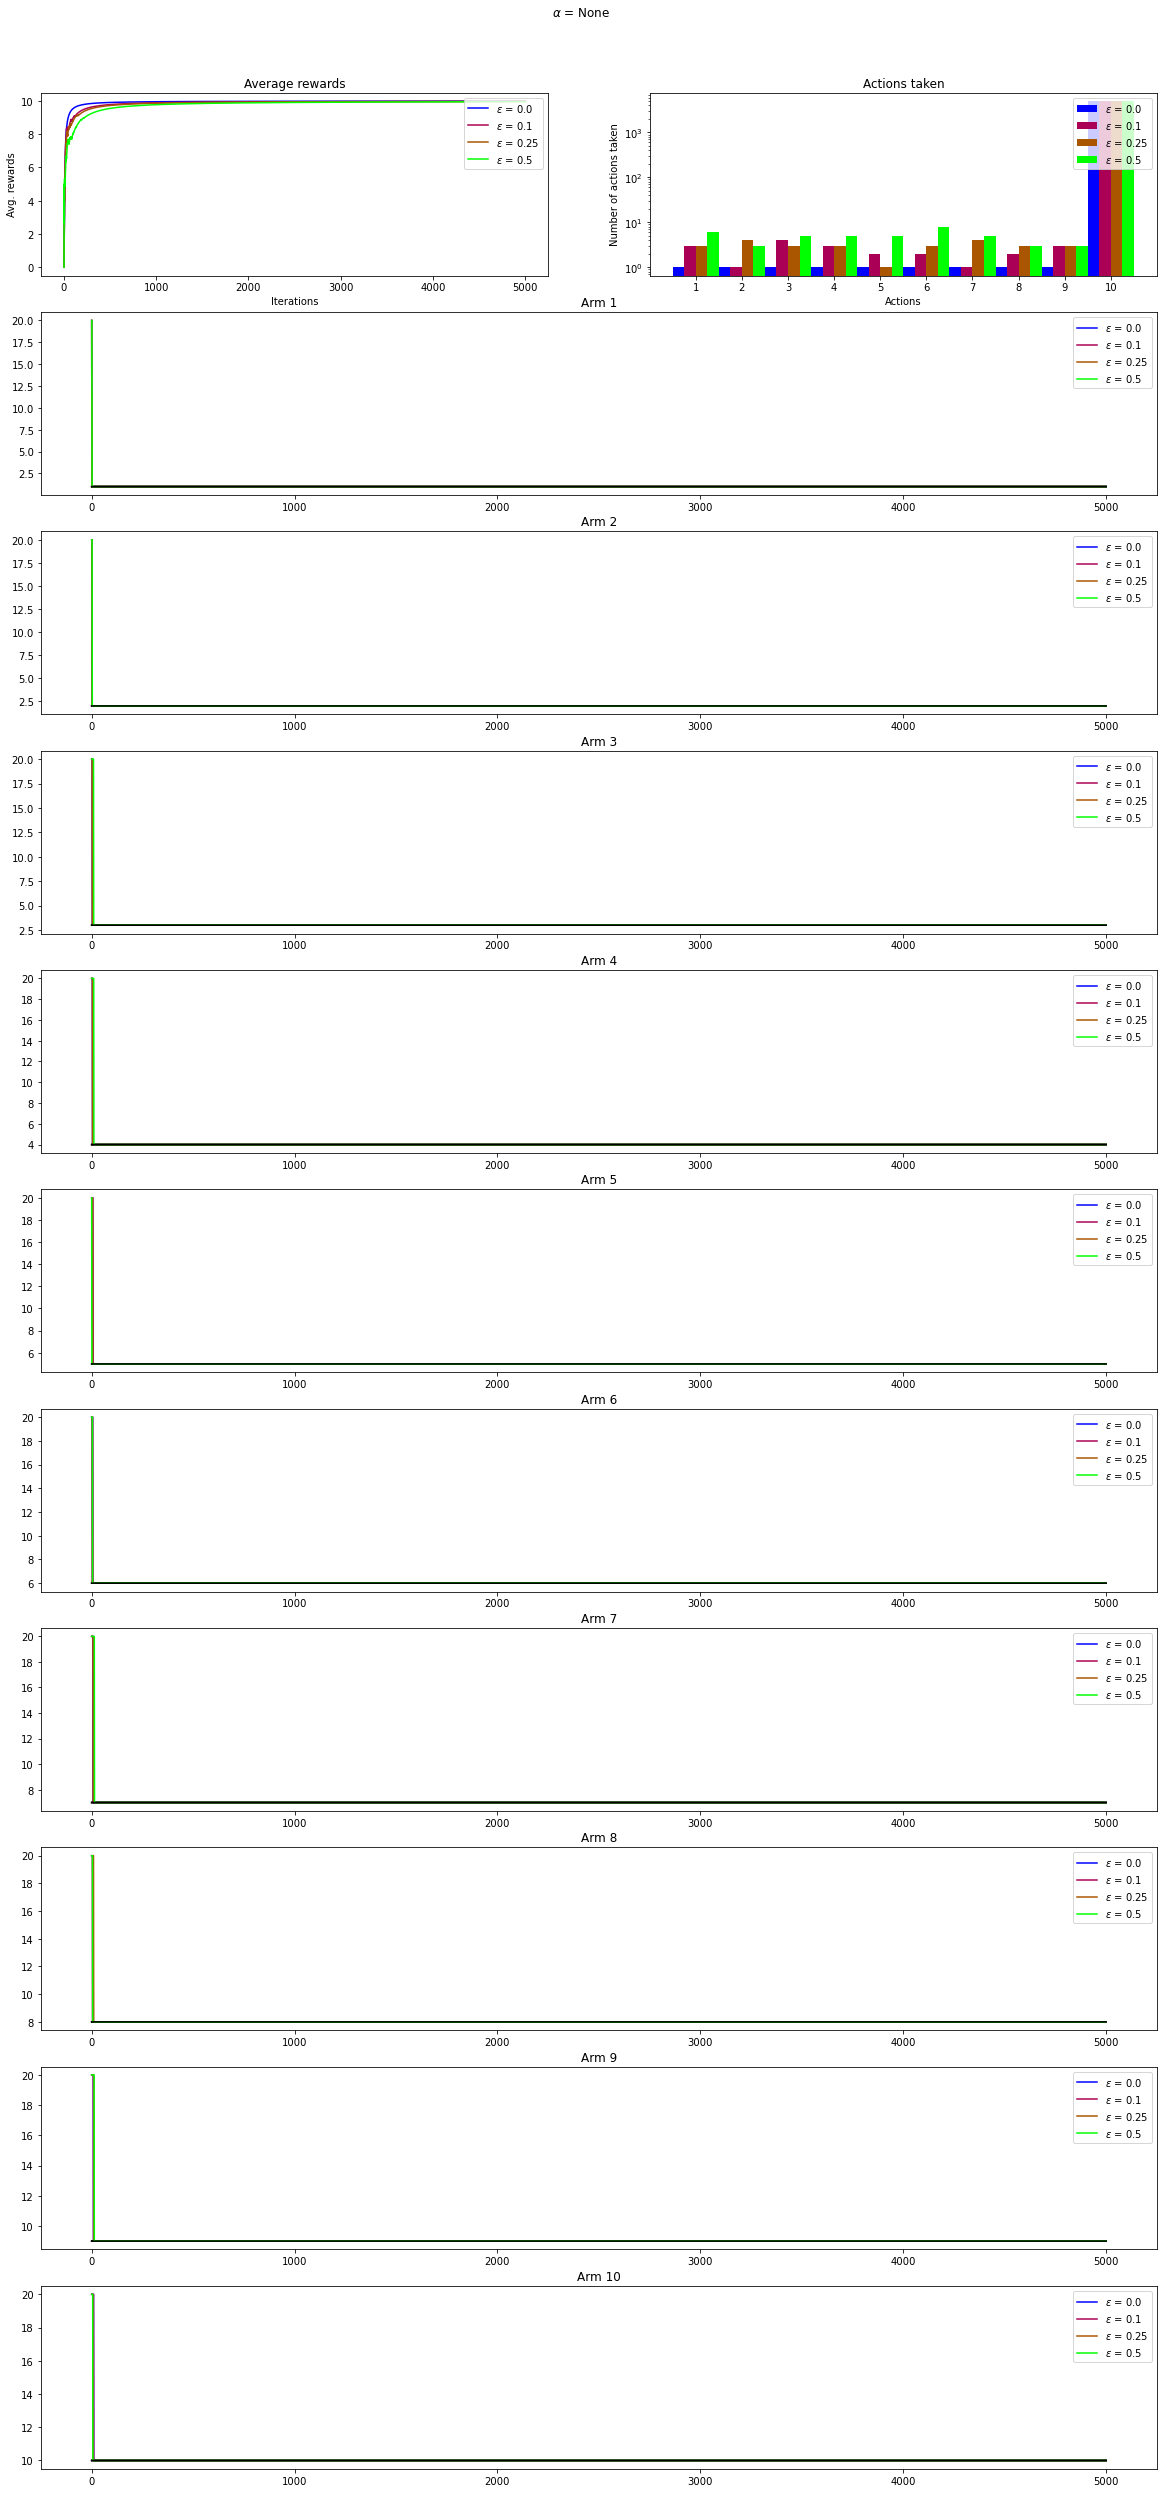

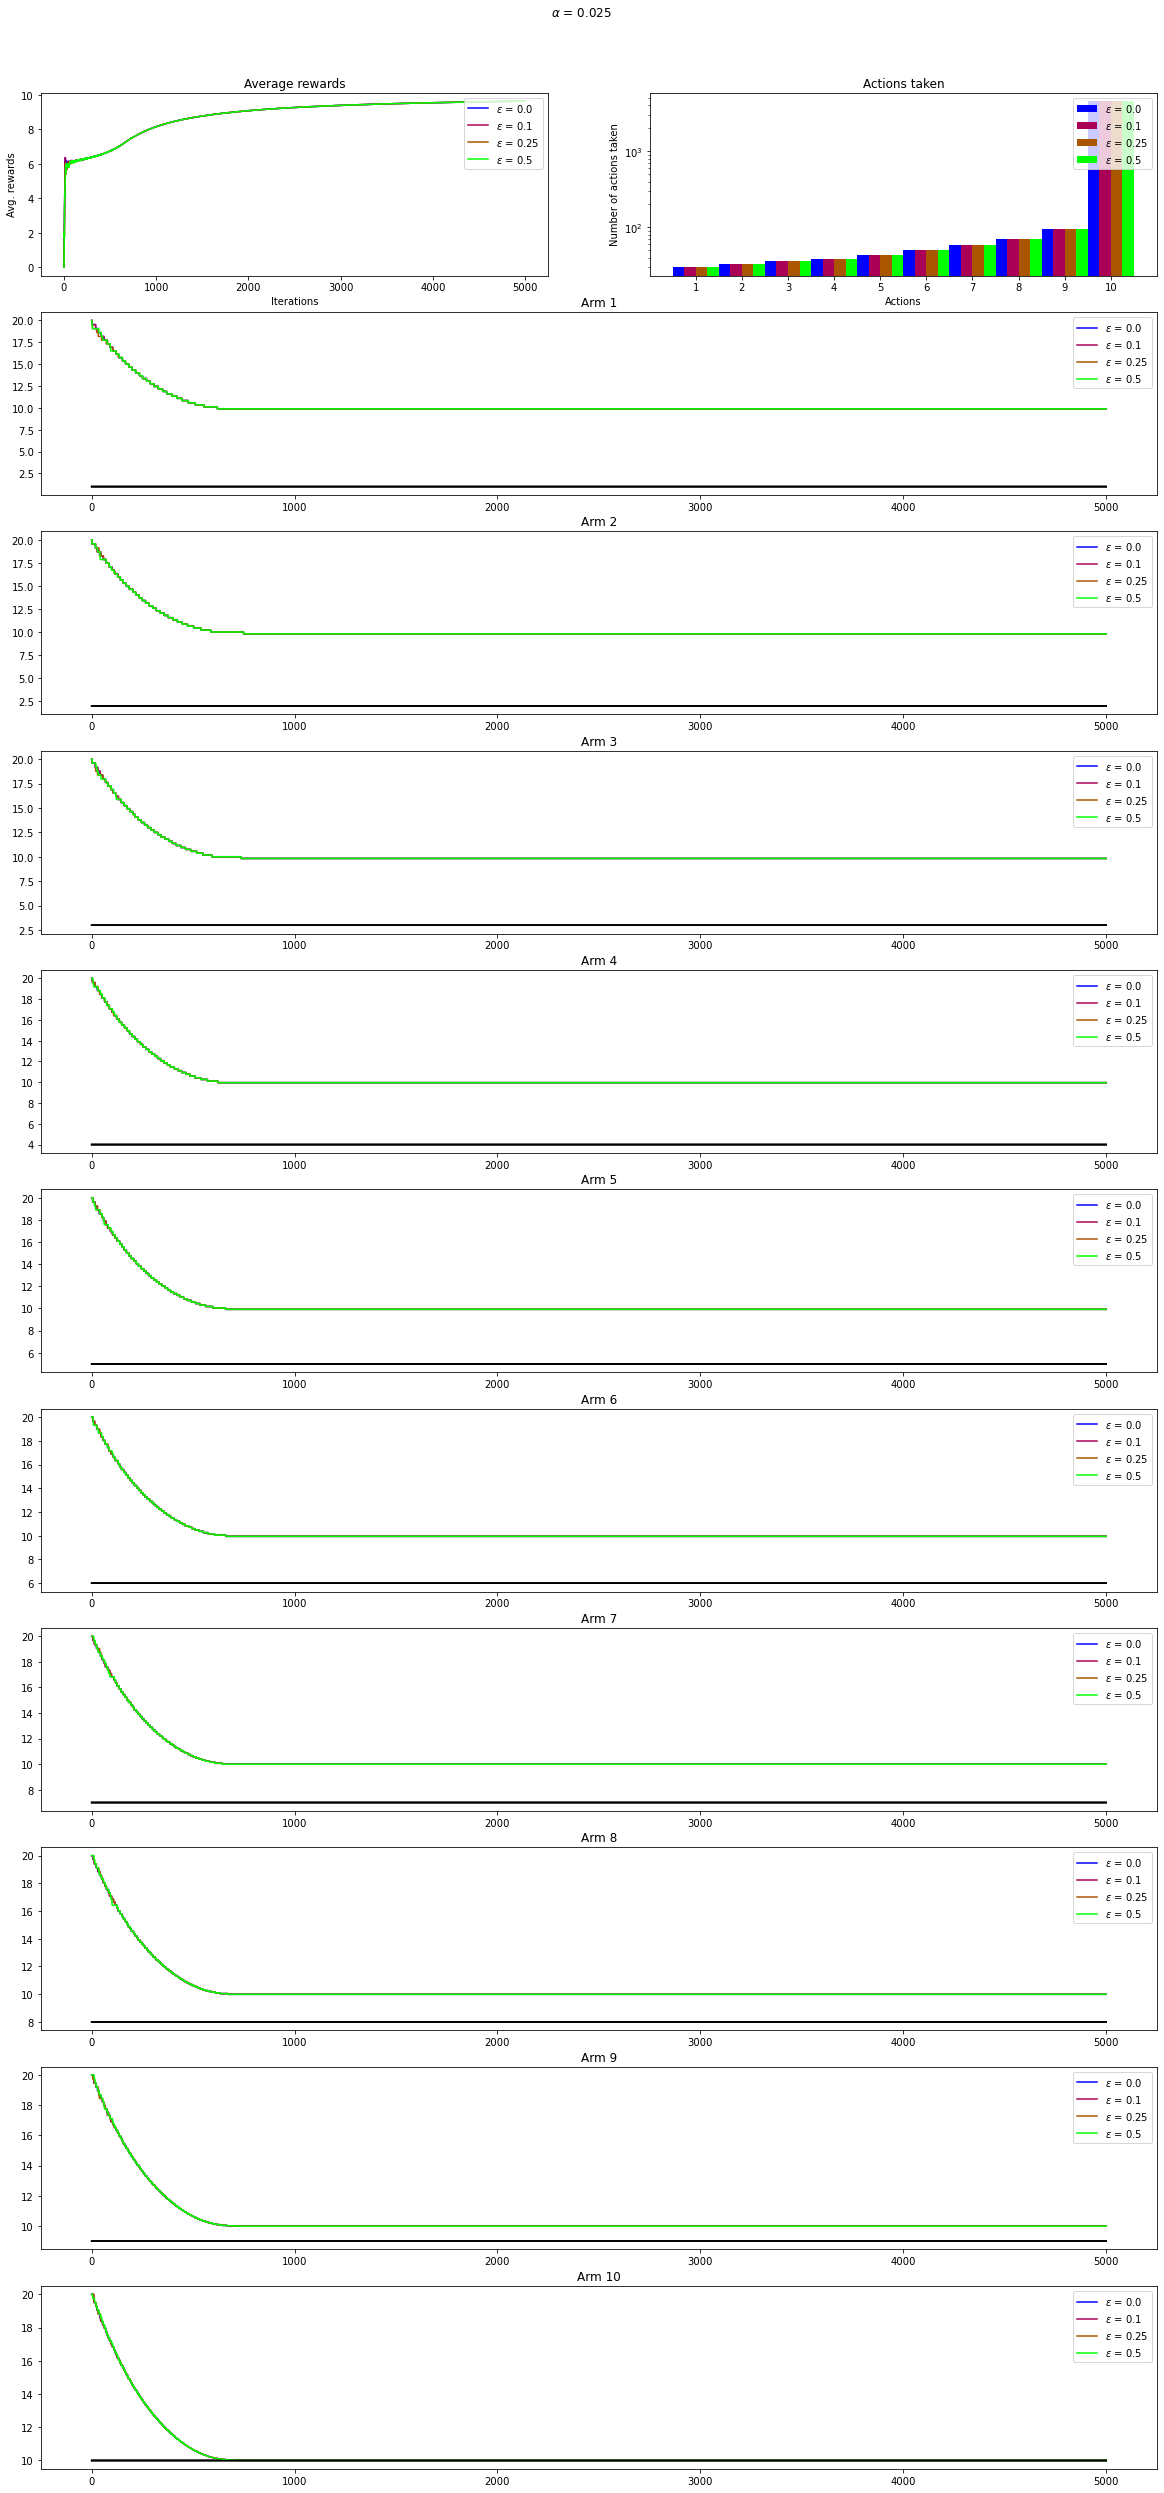

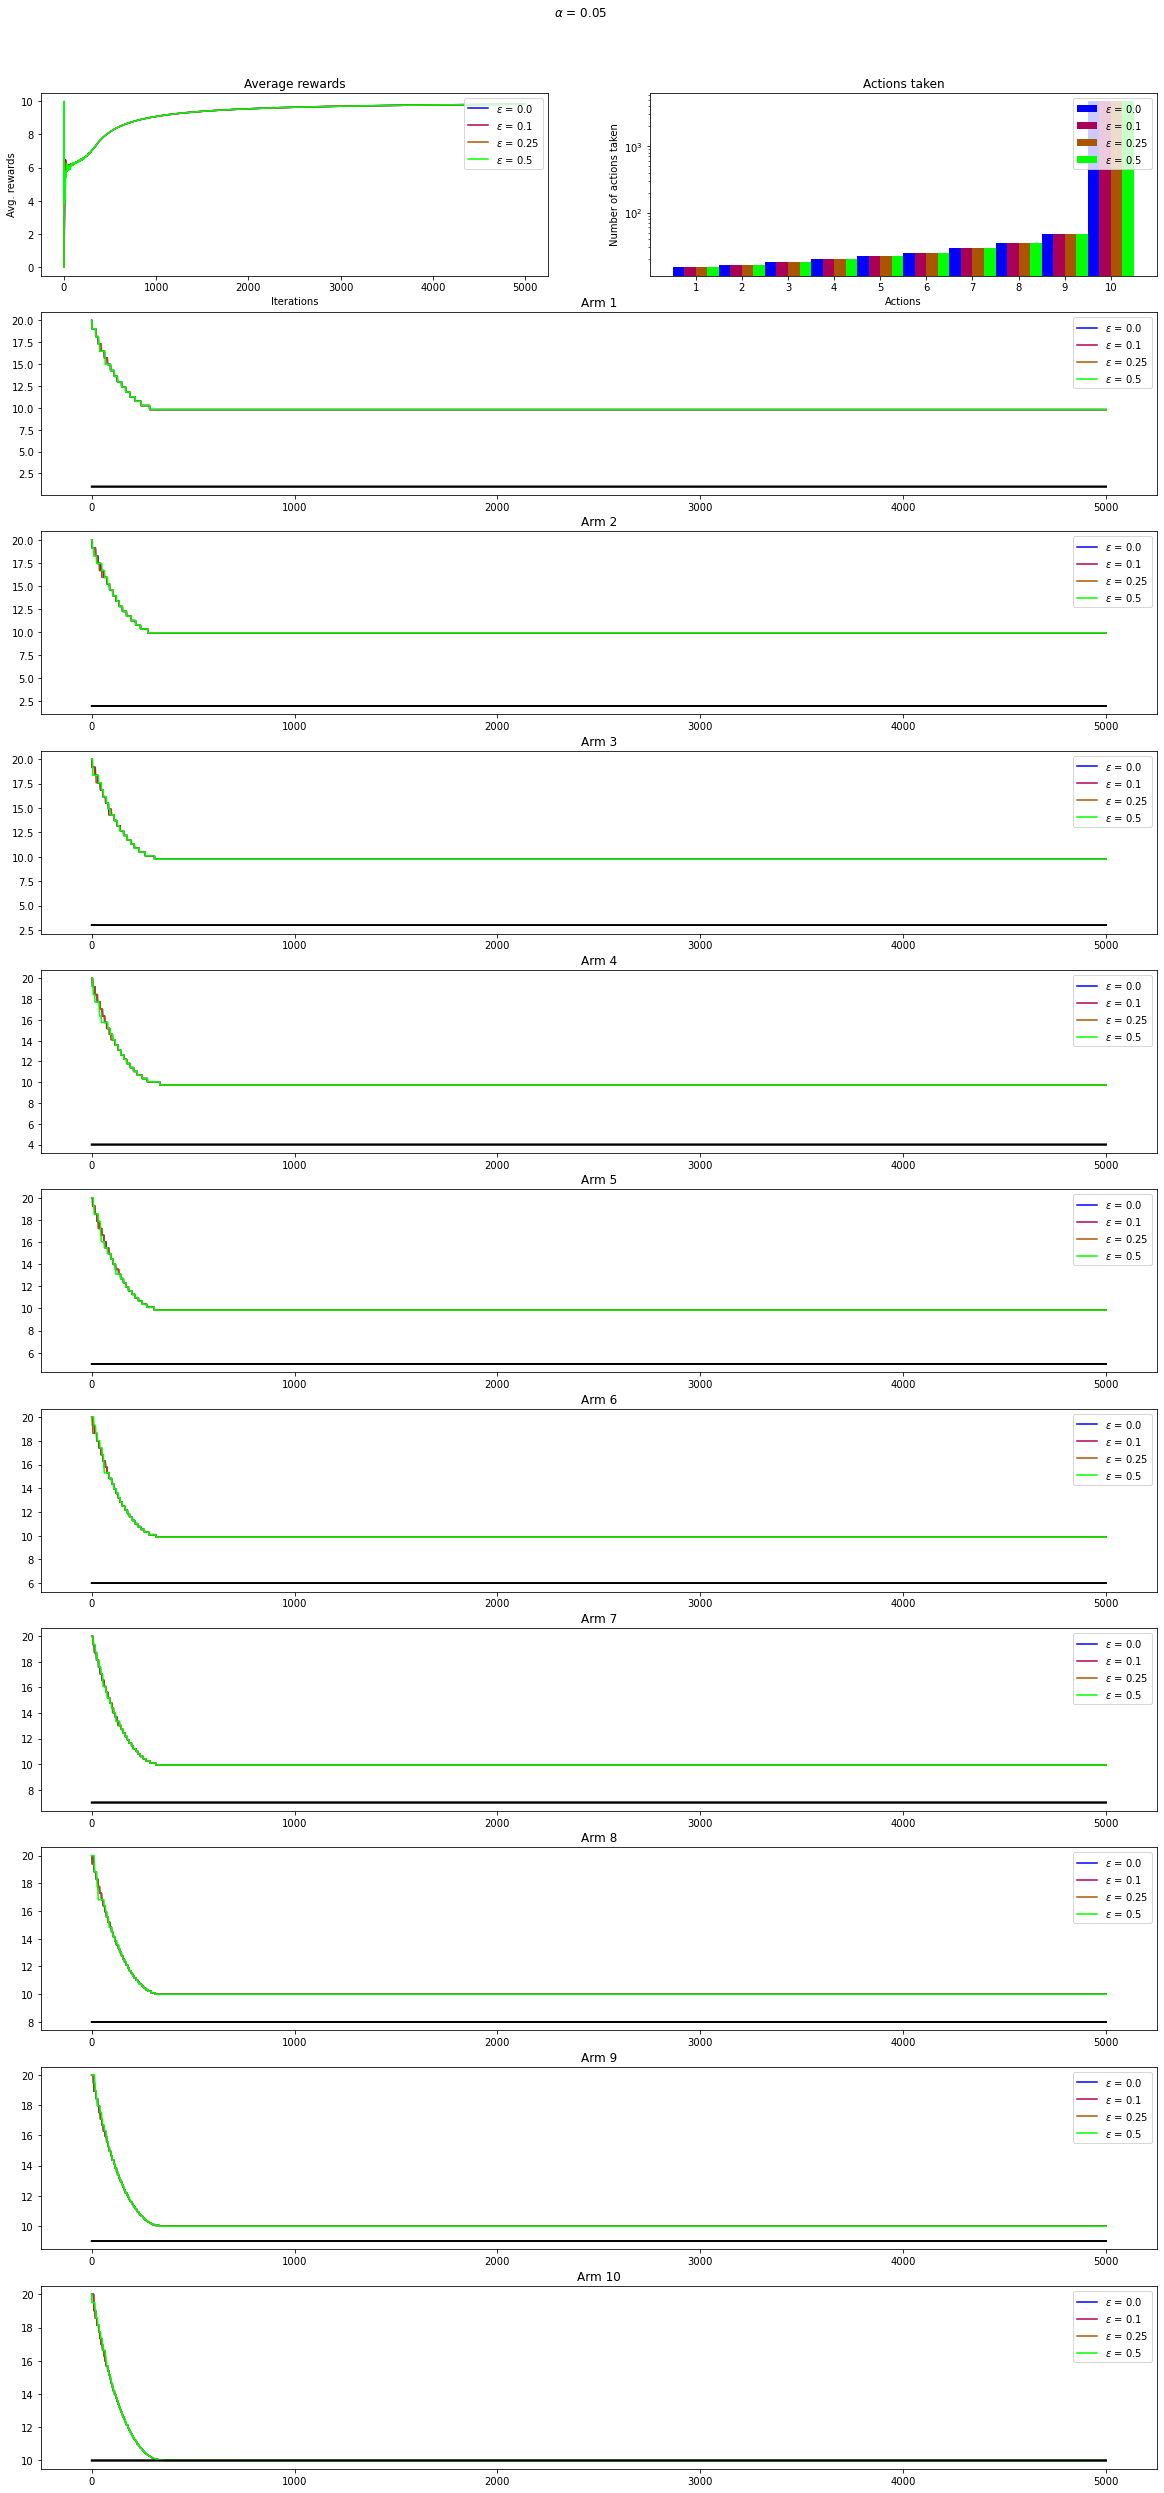

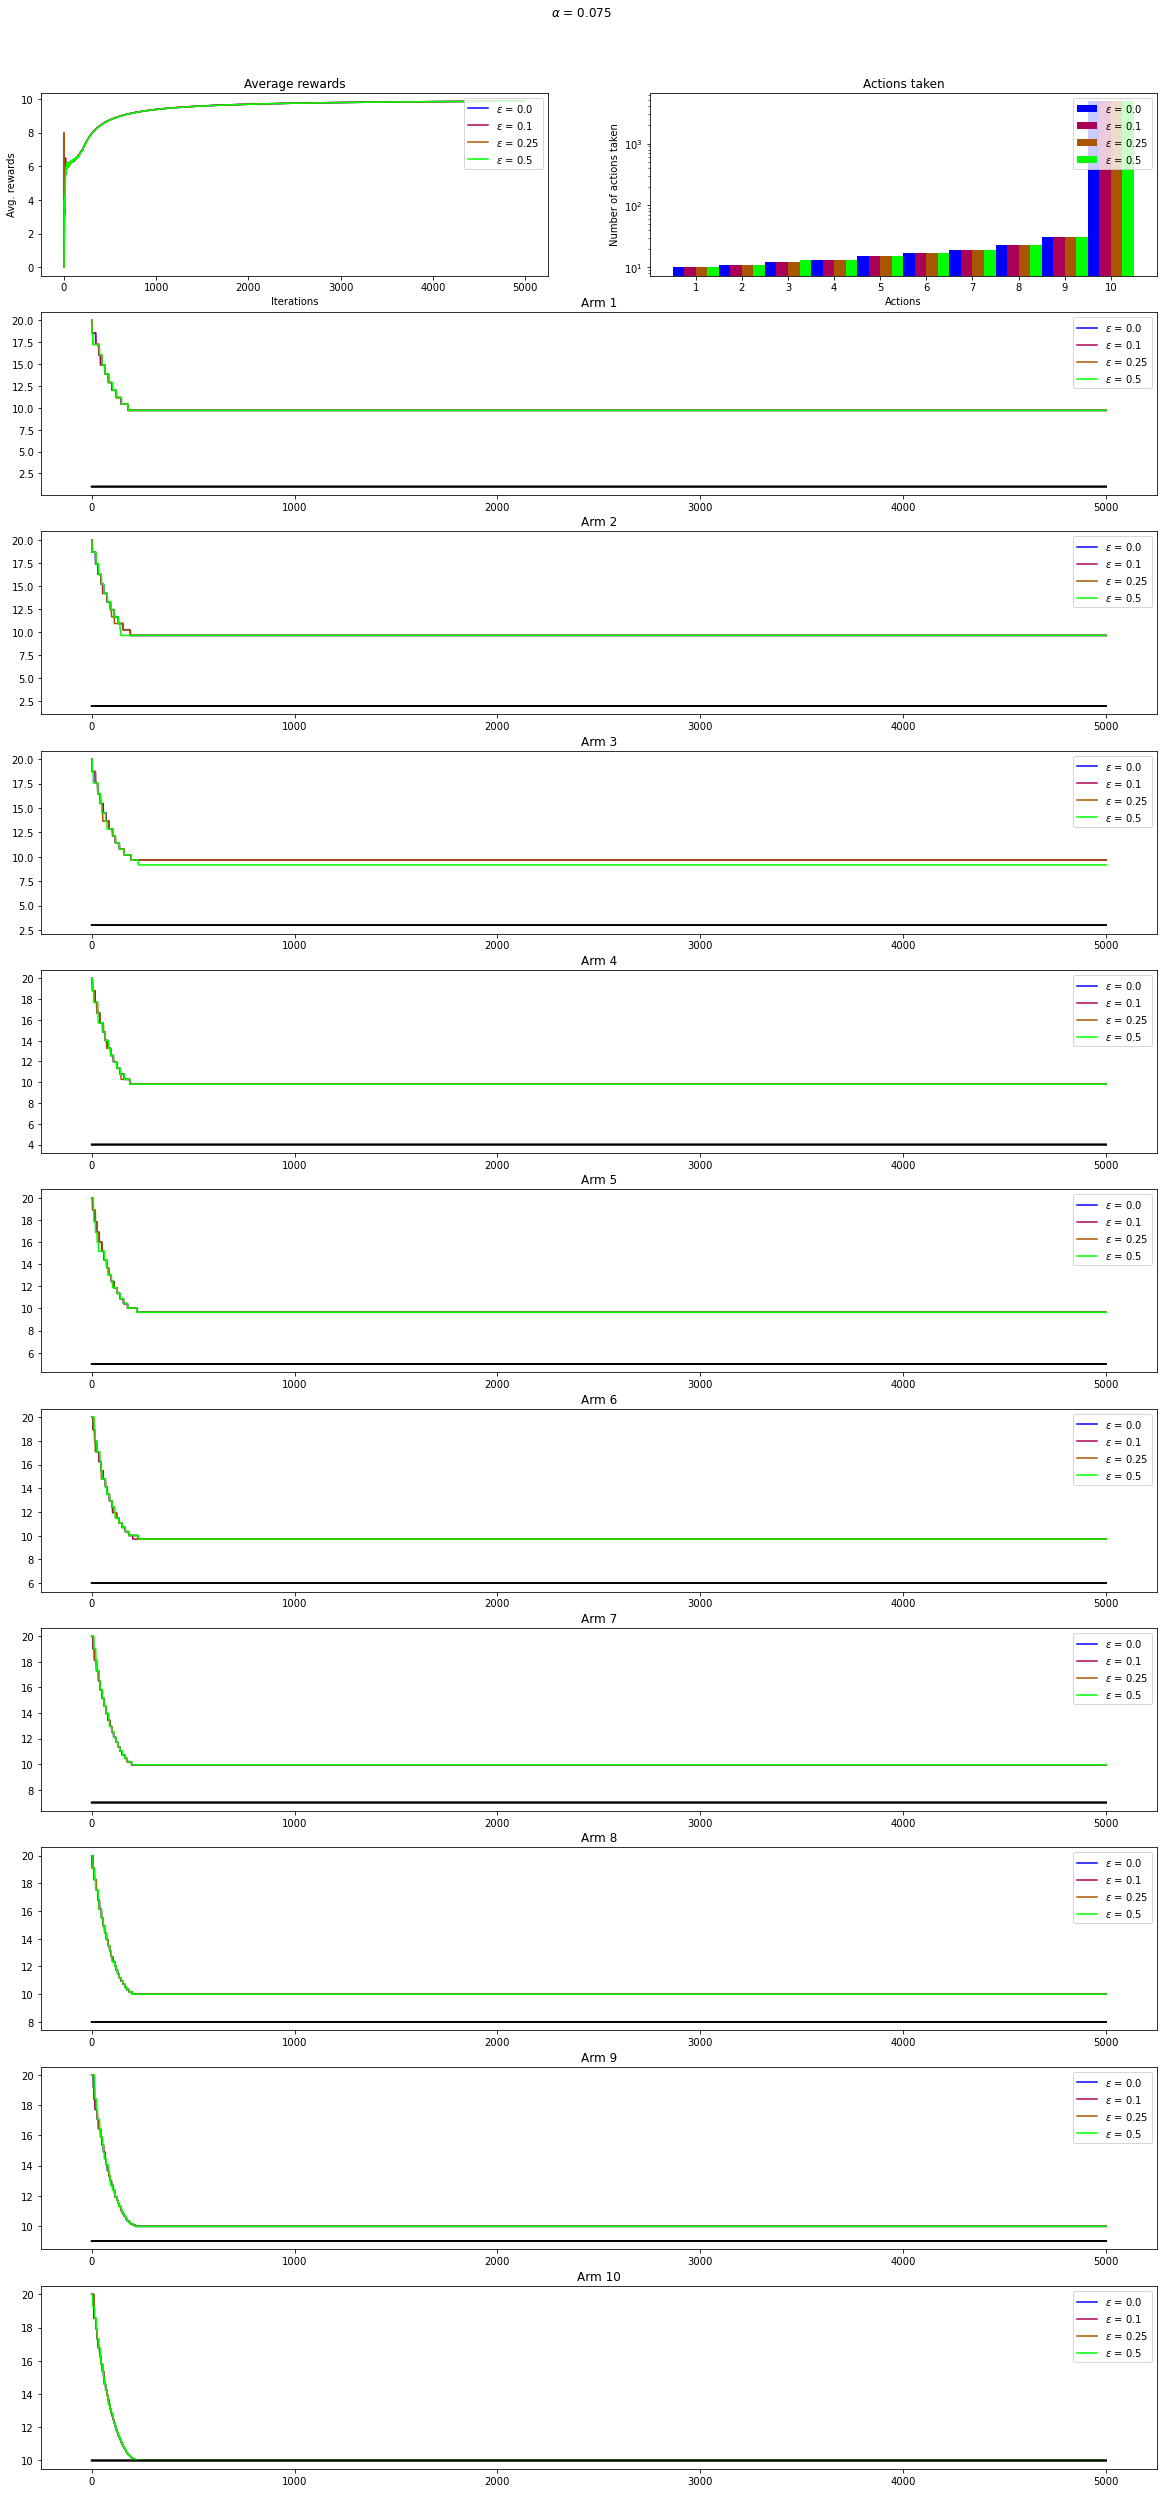

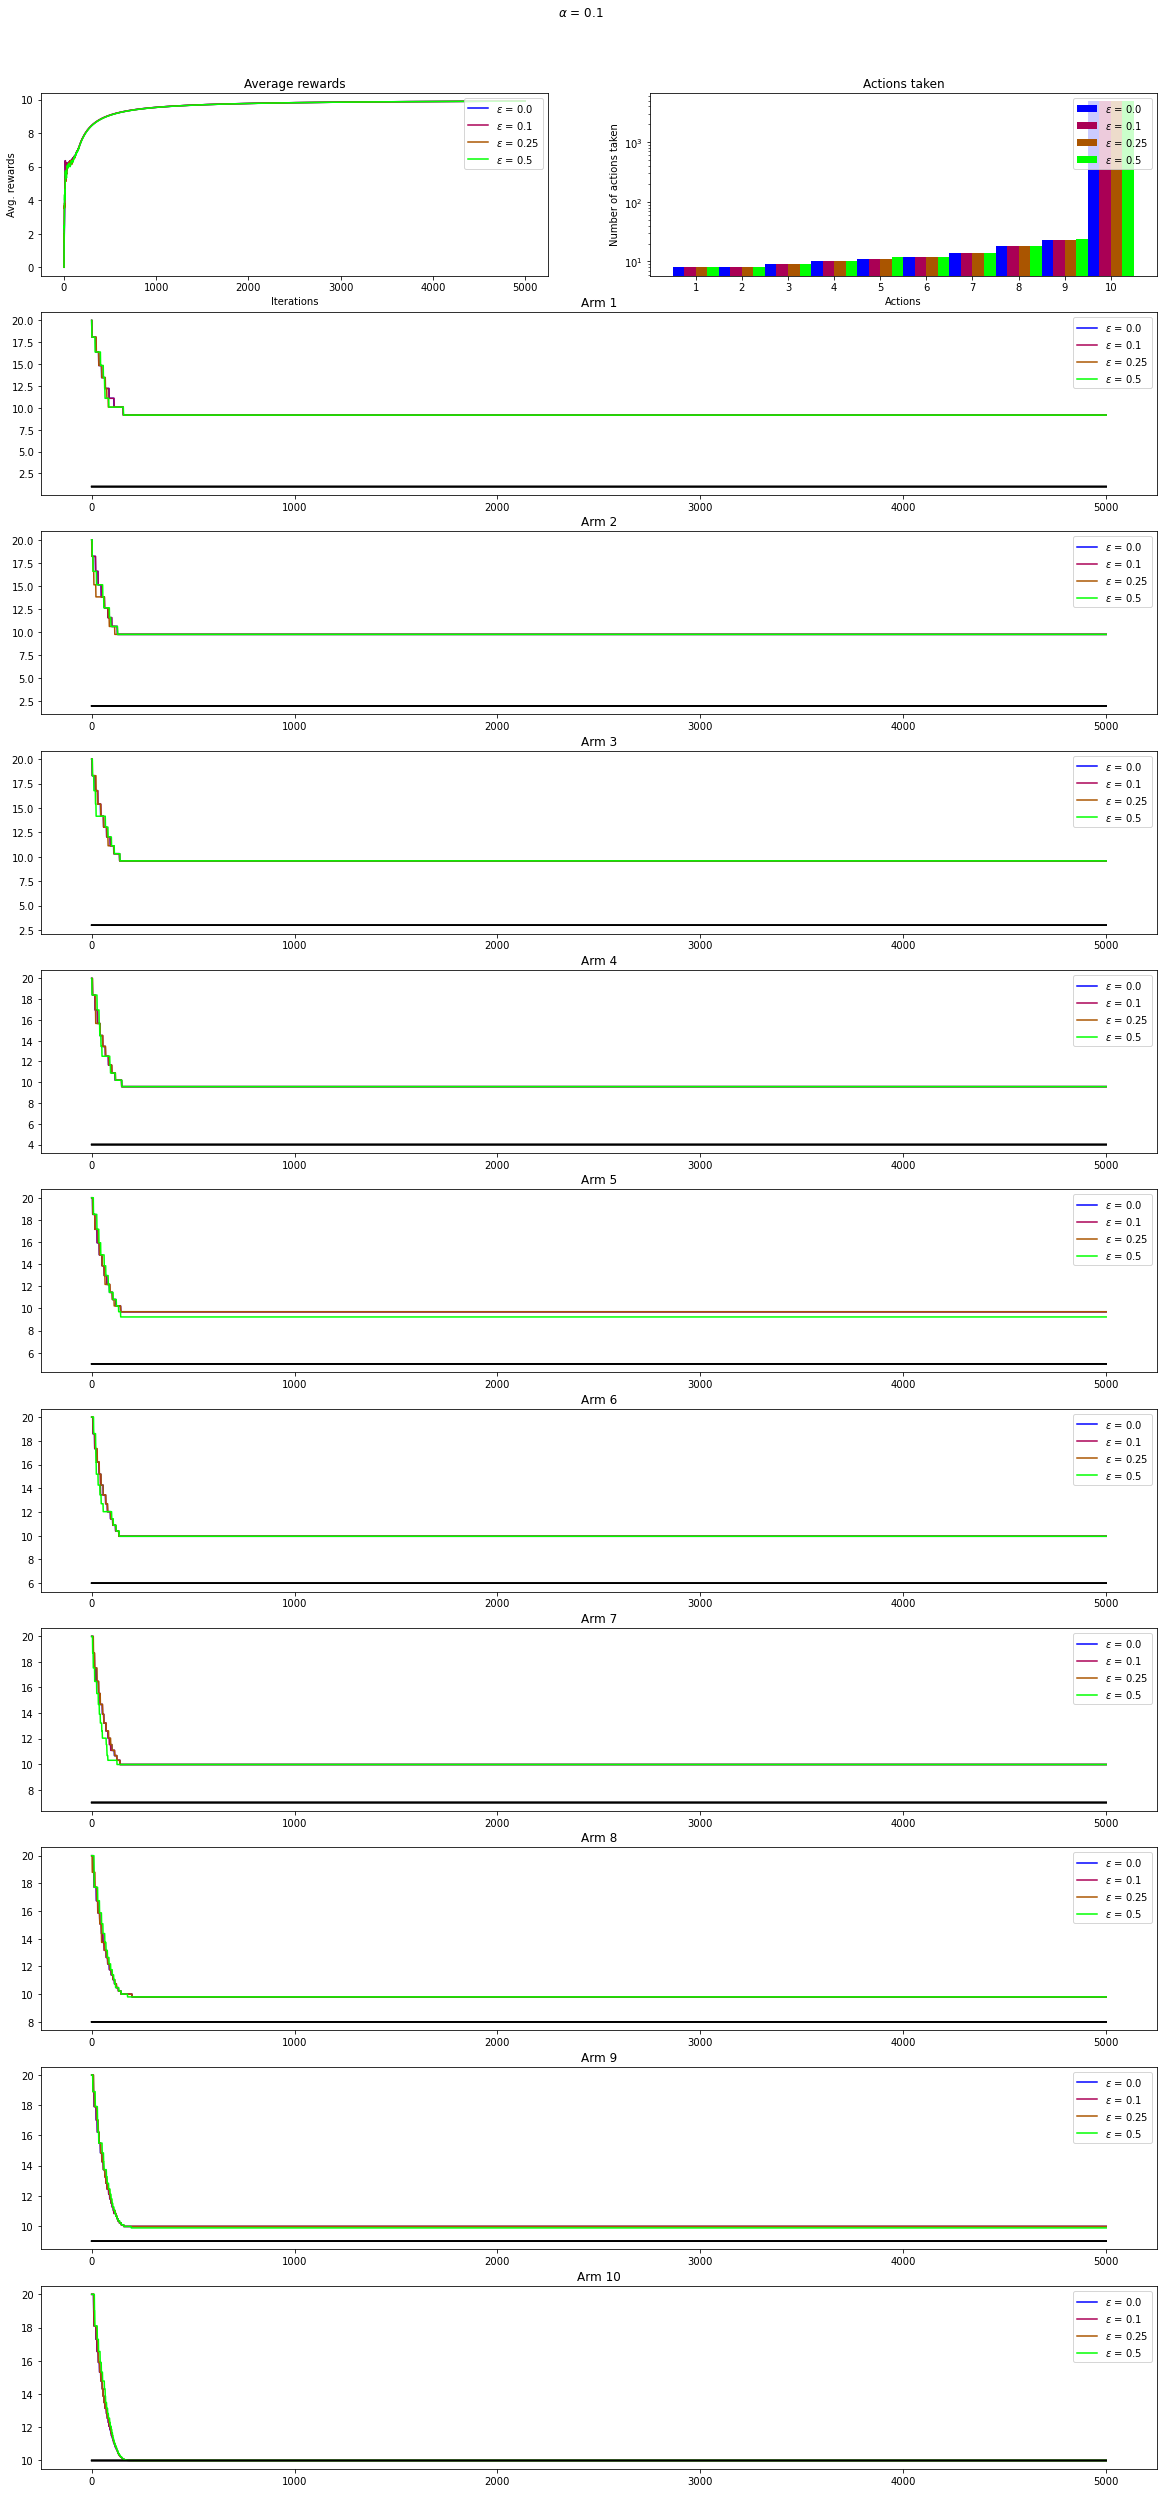

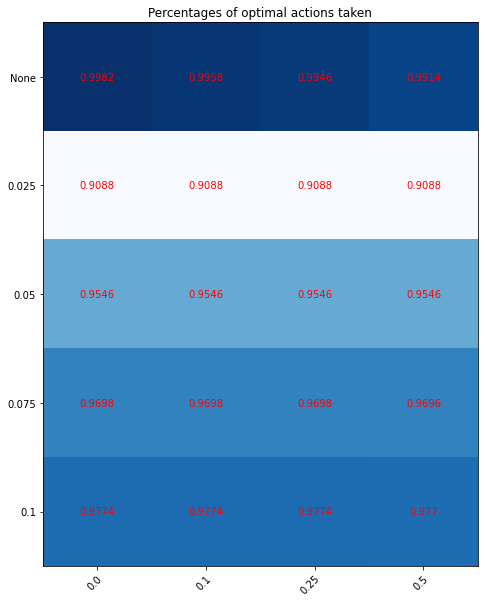

In [3]:
# Simulation parameters (some MUST be floats!).
iters = 5000
opt_init = 20.0
arms = 10
means = np.arange(1.0, float(arms + 1), 1.0)
sigmas = None
alphas = [None, 0.025, 0.05, 0.075, 0.1]
epsilons = [0.0, 0.1, 0.25, 0.5]
det = True
stat = True

eps_plots(iters, opt_init, arms, means, sigmas, alphas, epsilons, det, stat)

## Deterministic, non-stationary case

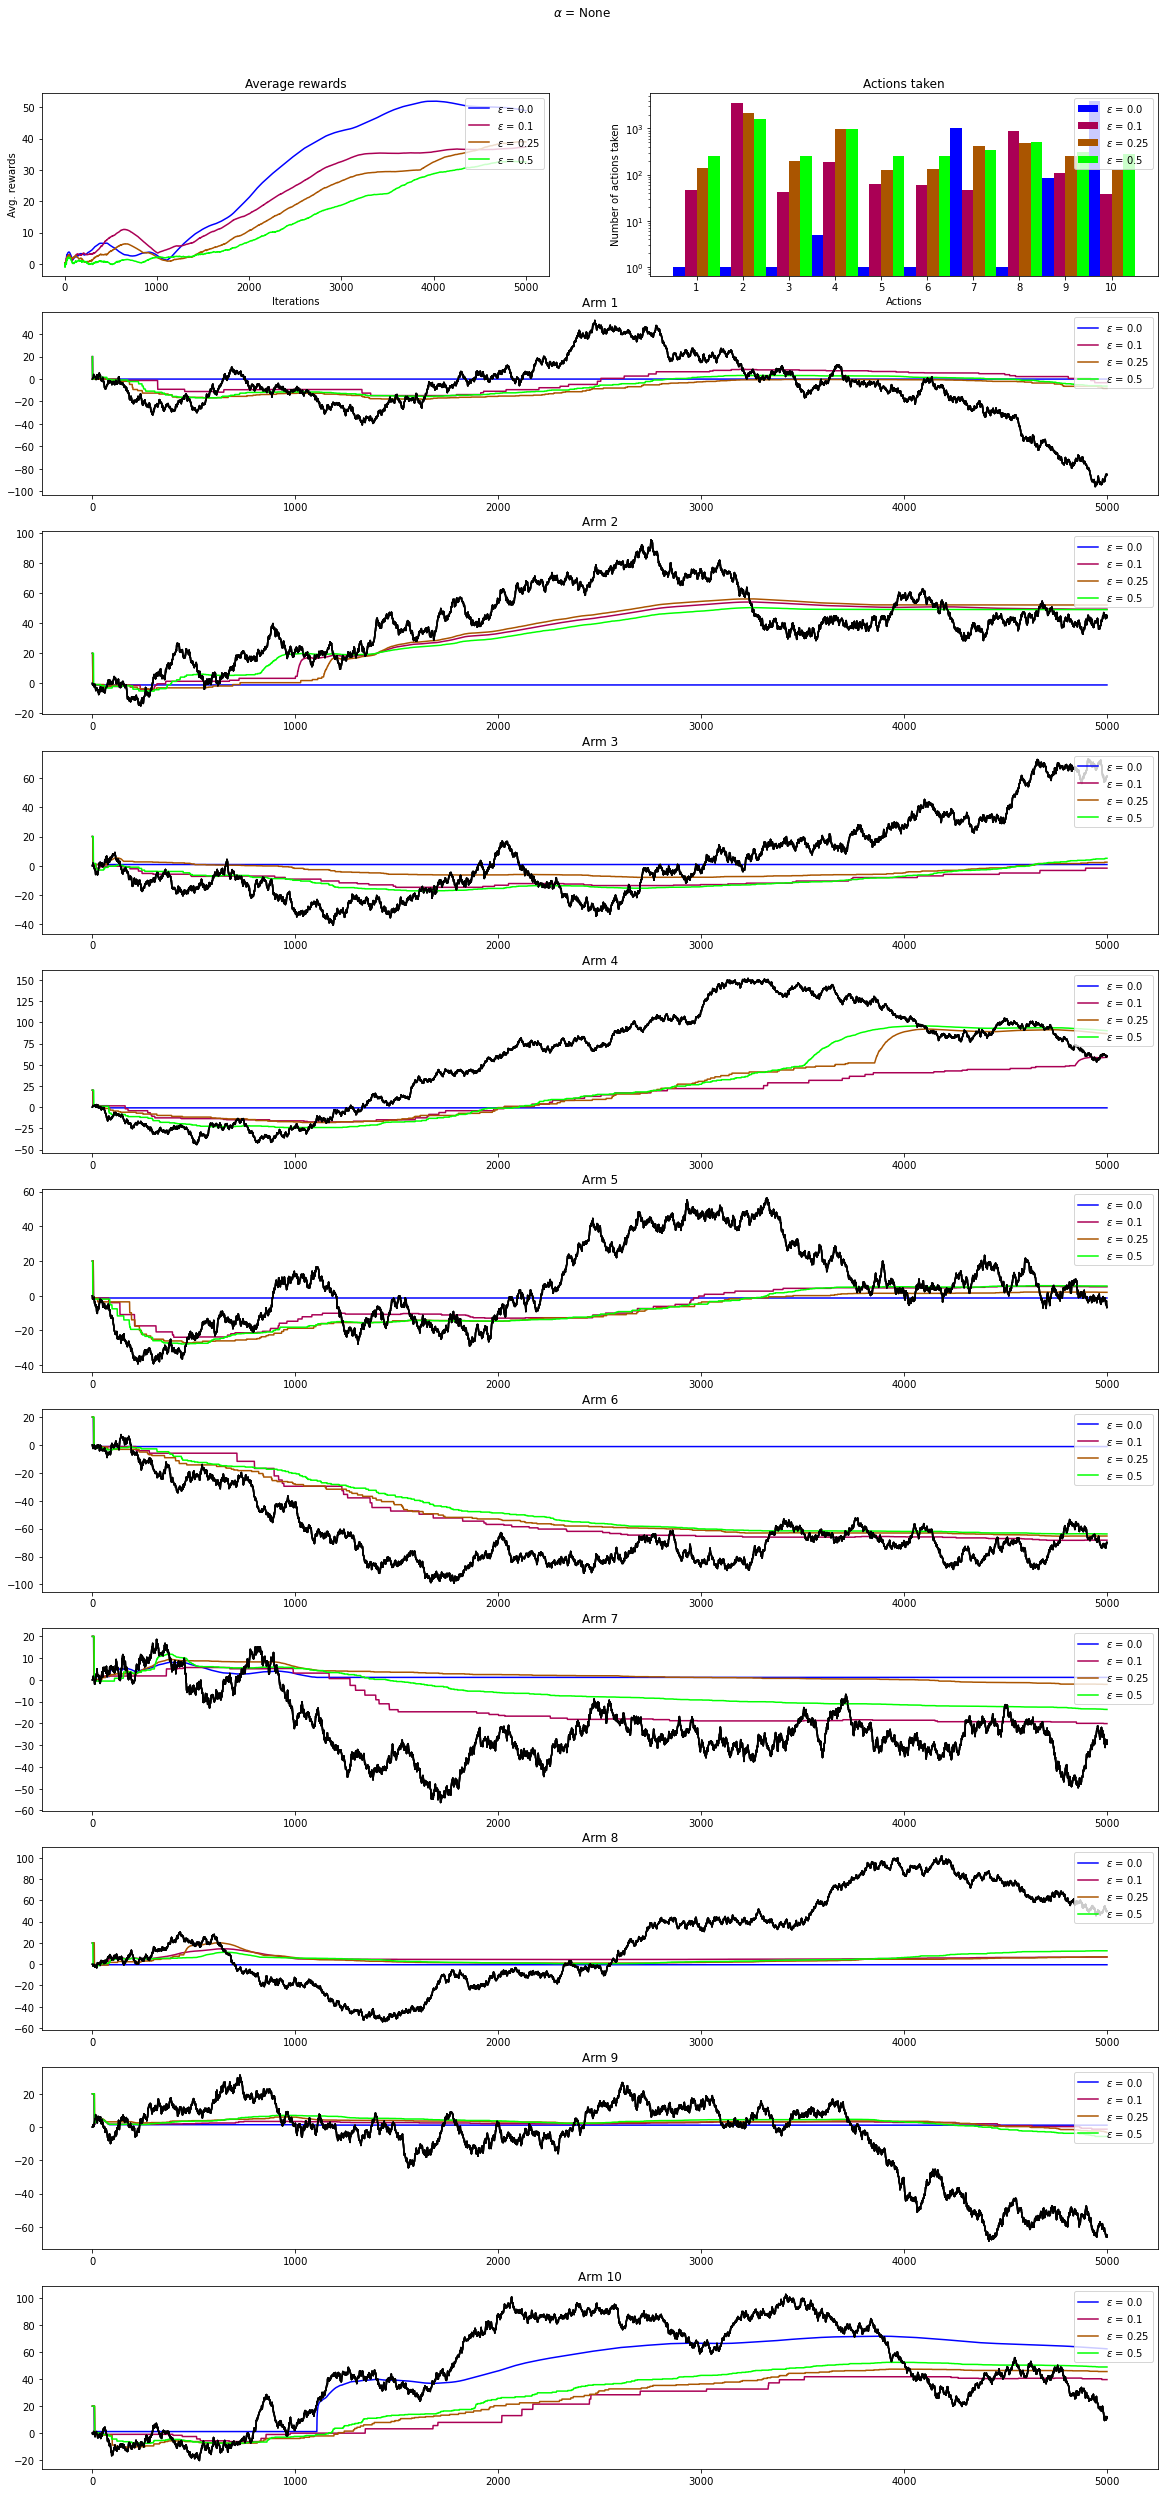

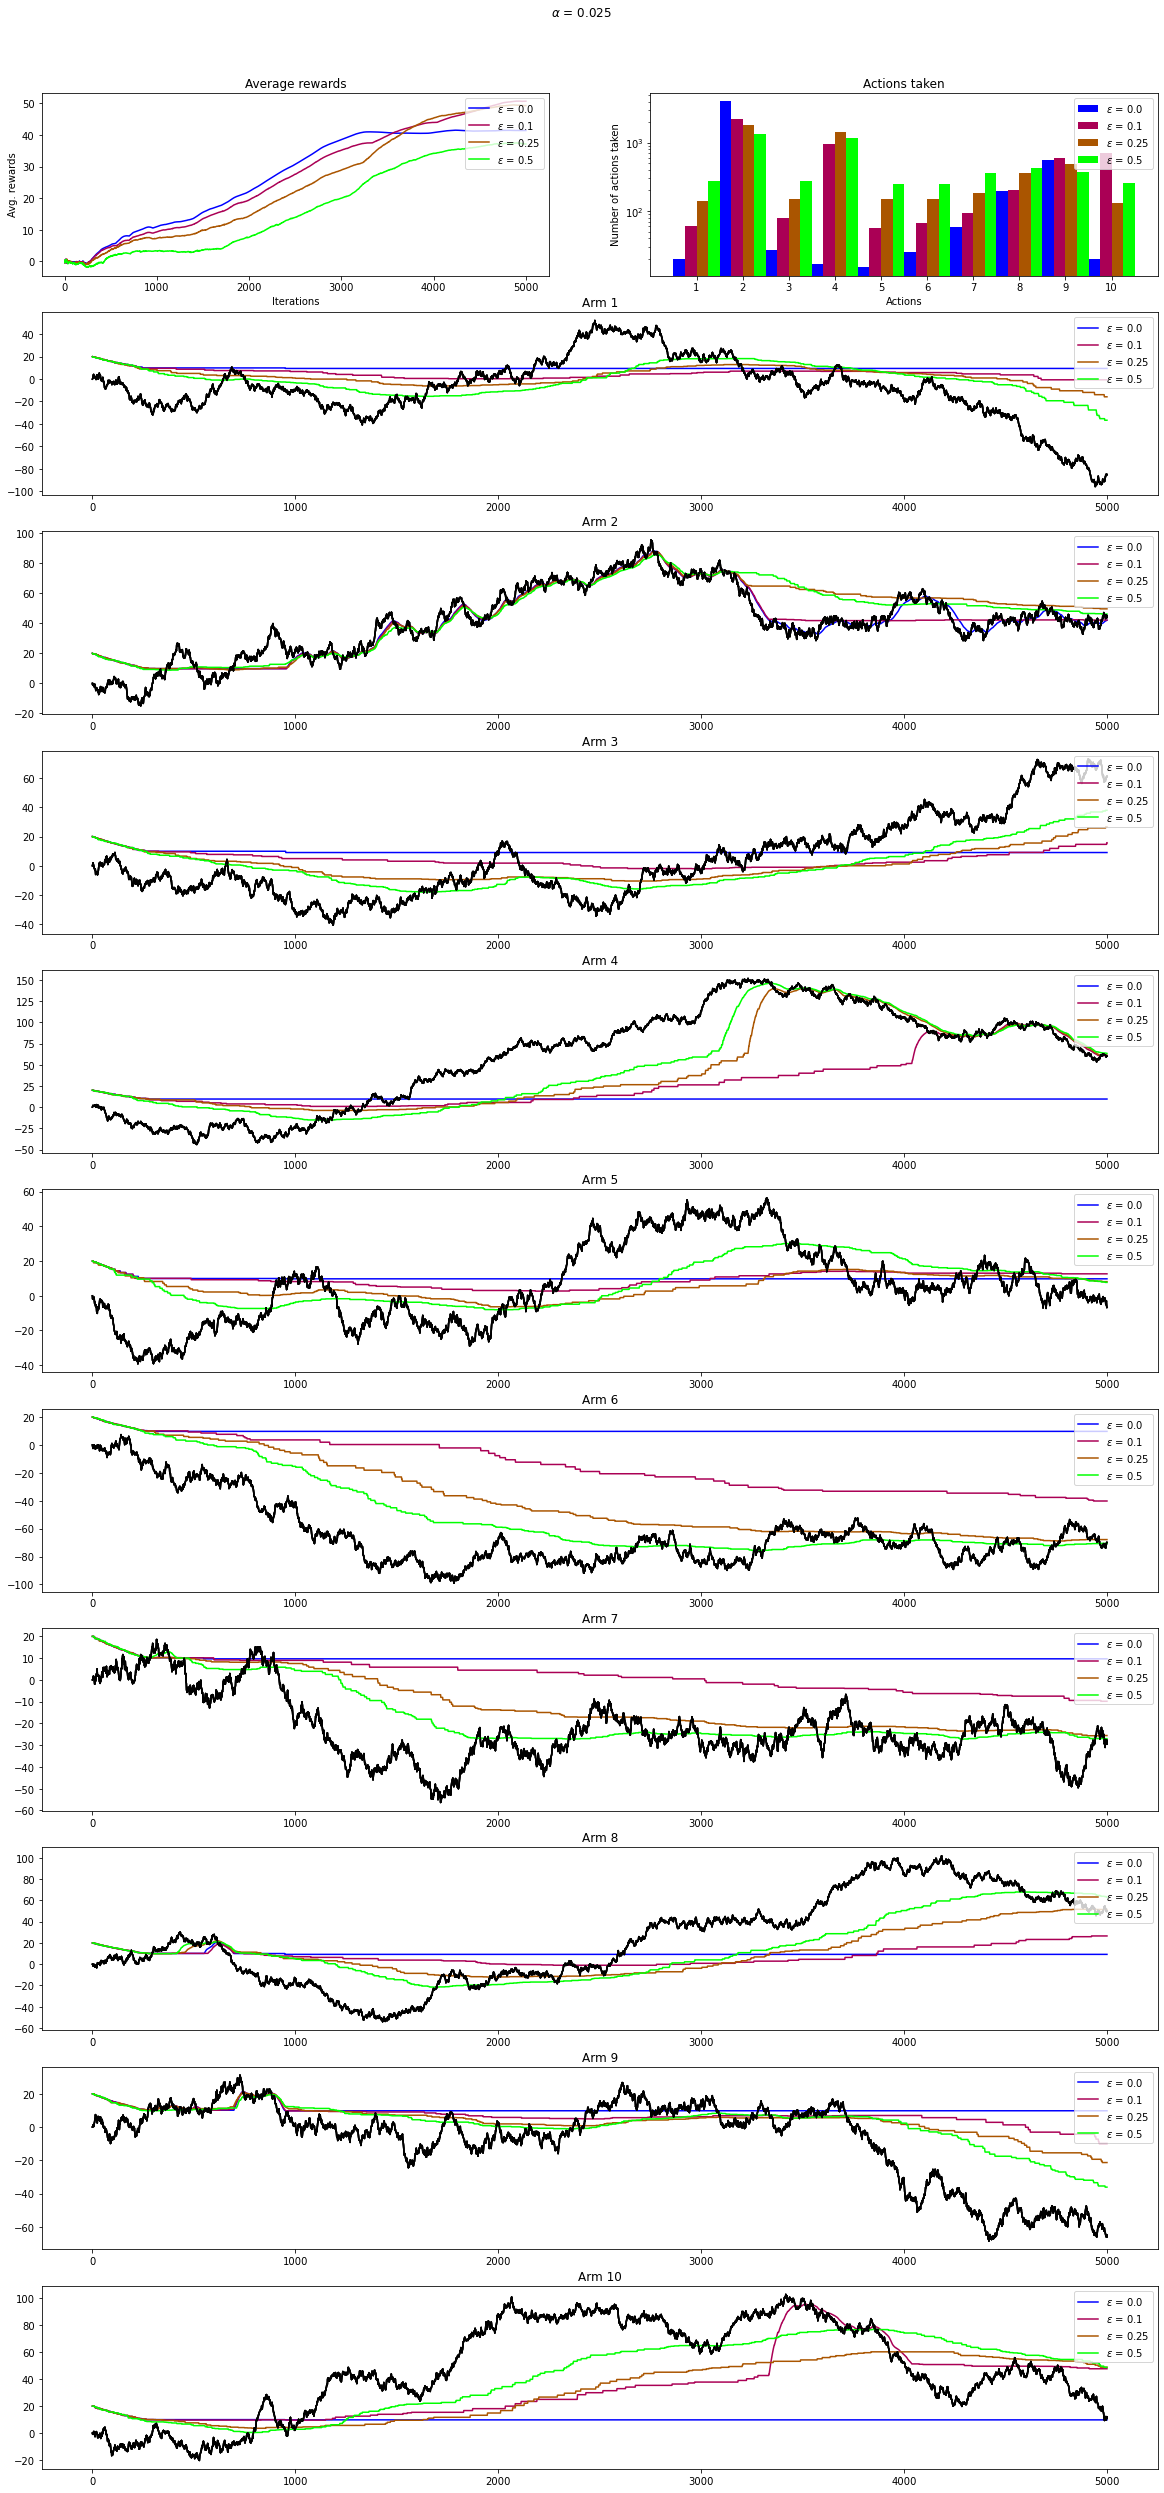

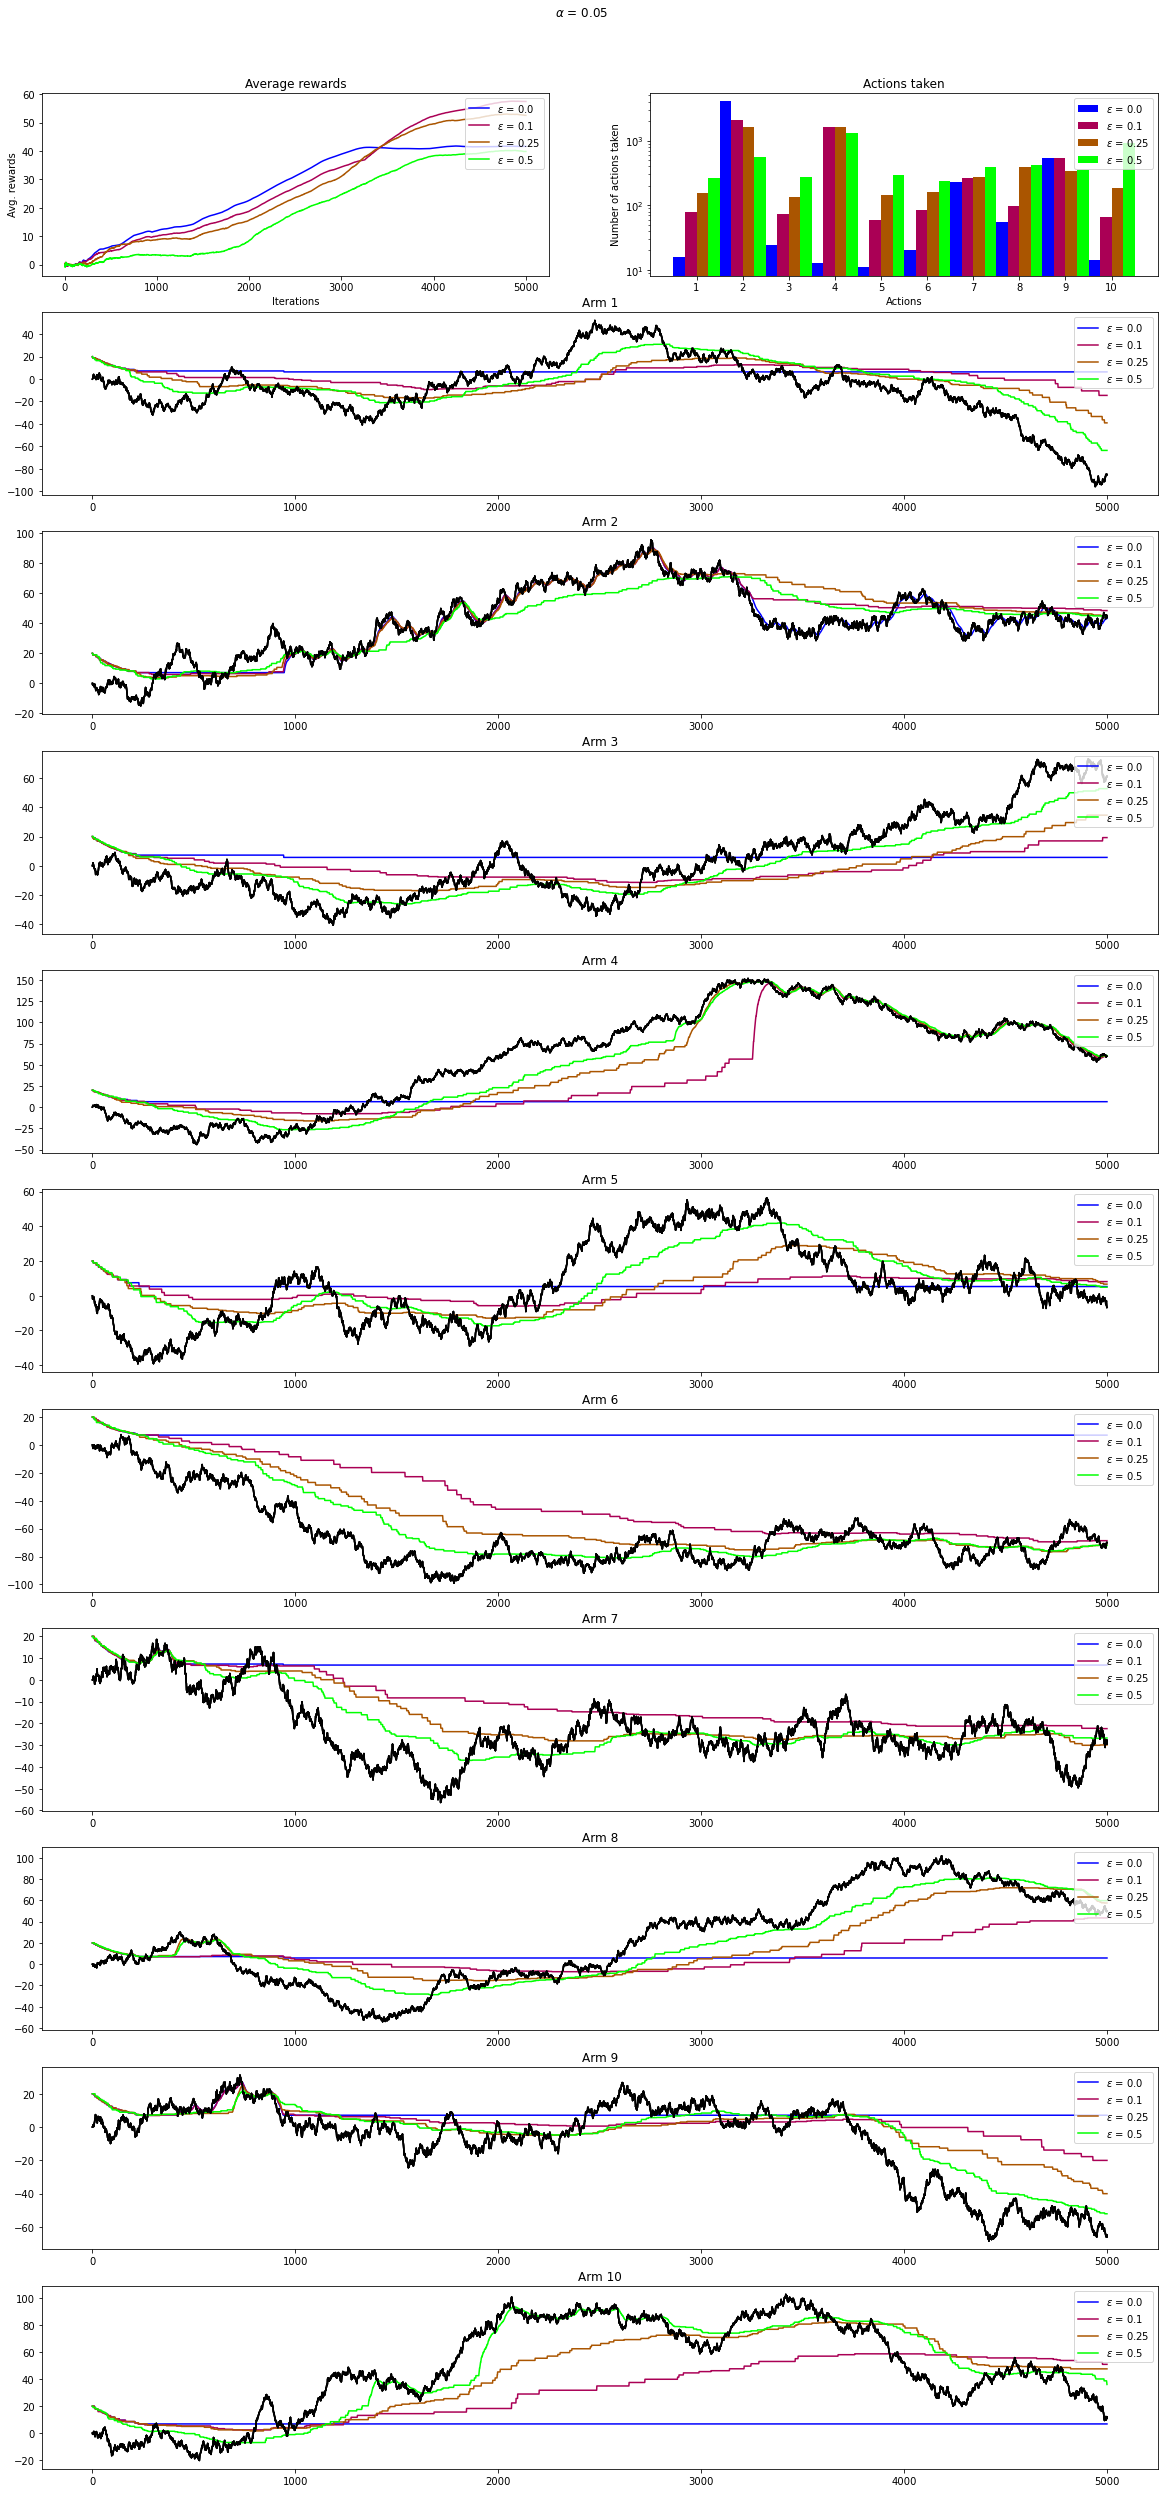

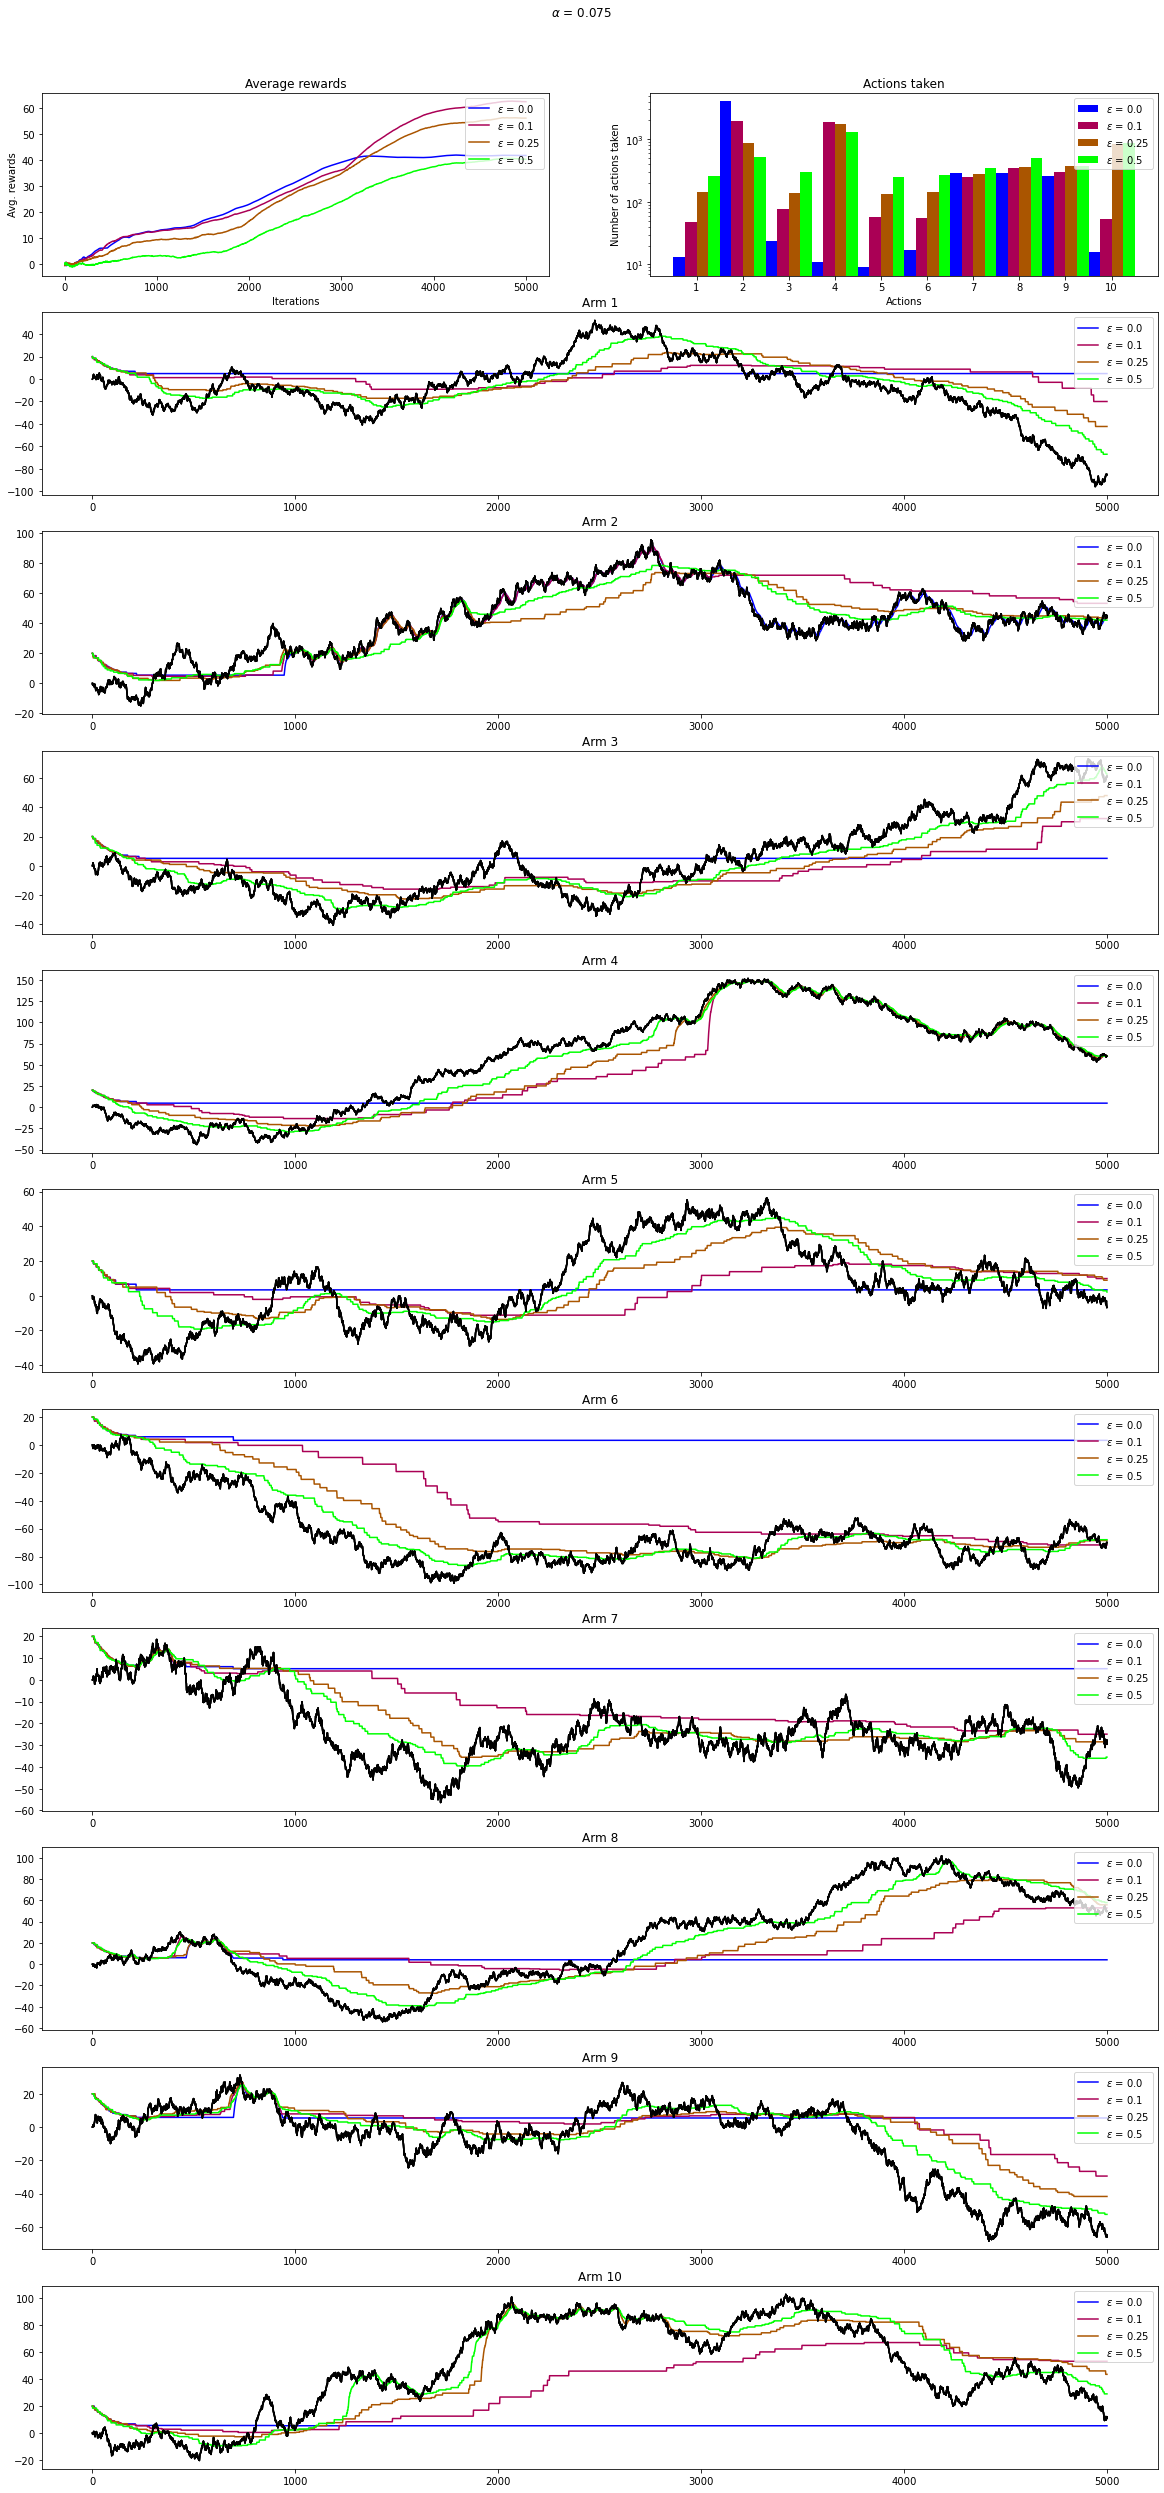

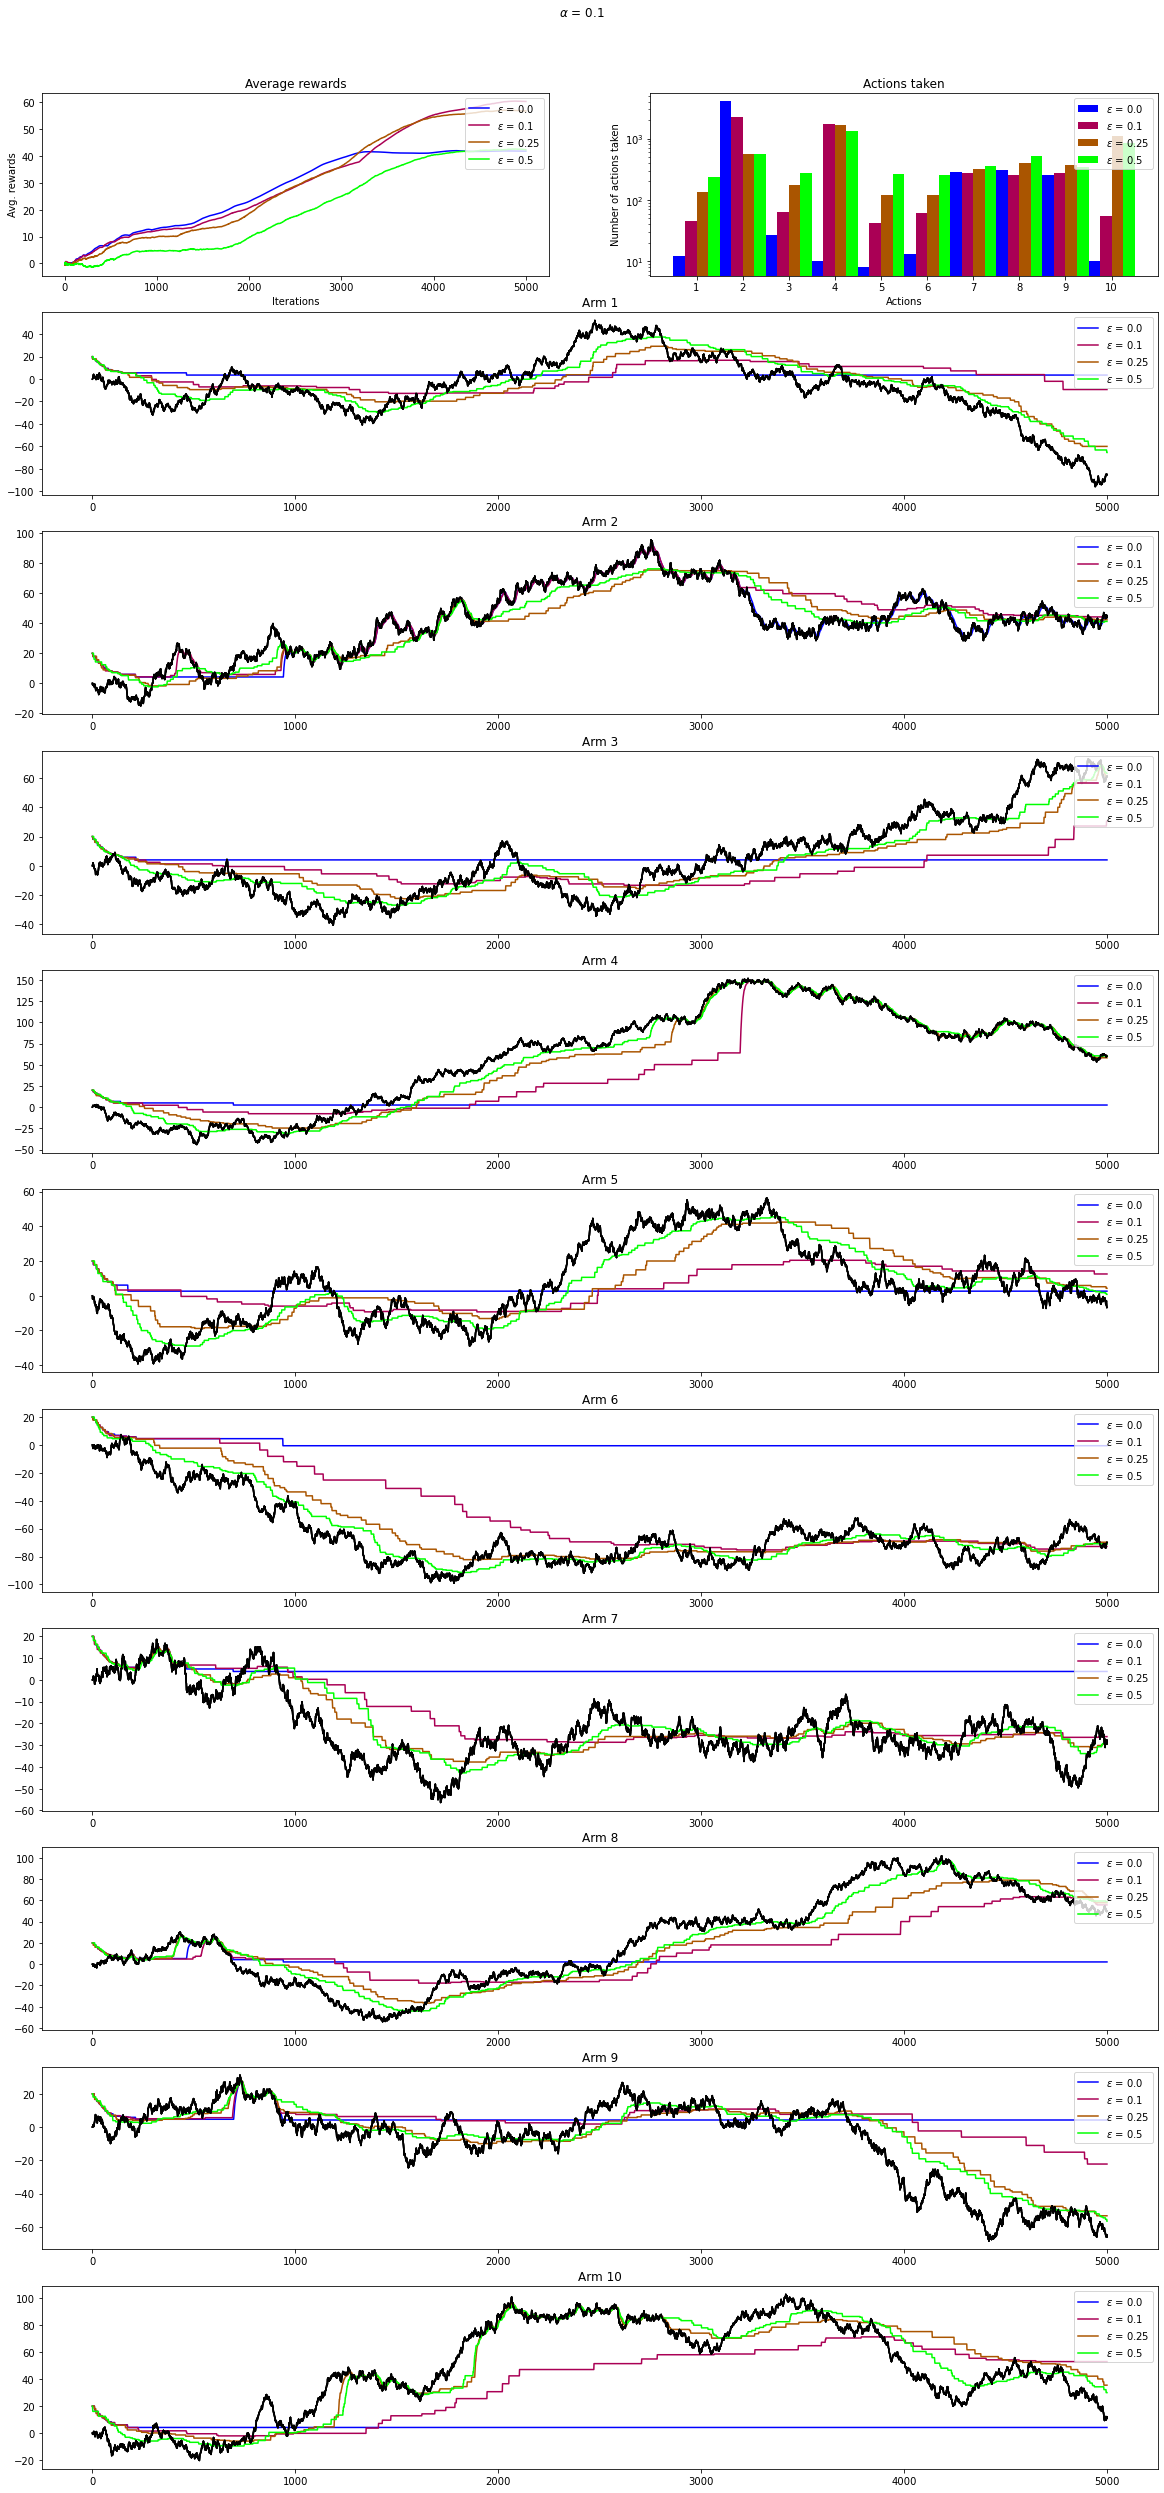

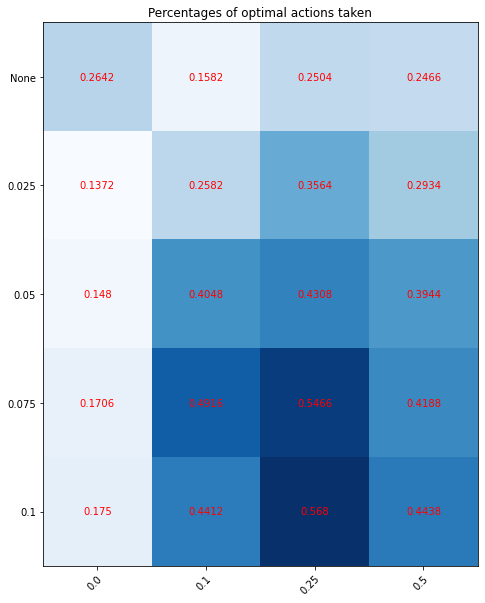

In [4]:
# Simulation parameters (some MUST be floats!).
iters = 5000
opt_init = 20.0
arms = 10
means = np.full(arms, 0.0)
sigmas = None
alphas = [None, 0.025, 0.05, 0.075, 0.1]
epsilons = [0.0, 0.1, 0.25, 0.5]
det = True
stat = False

eps_plots(iters, opt_init, arms, means, sigmas, alphas, epsilons, det, stat)

## Stochastic, stationary case

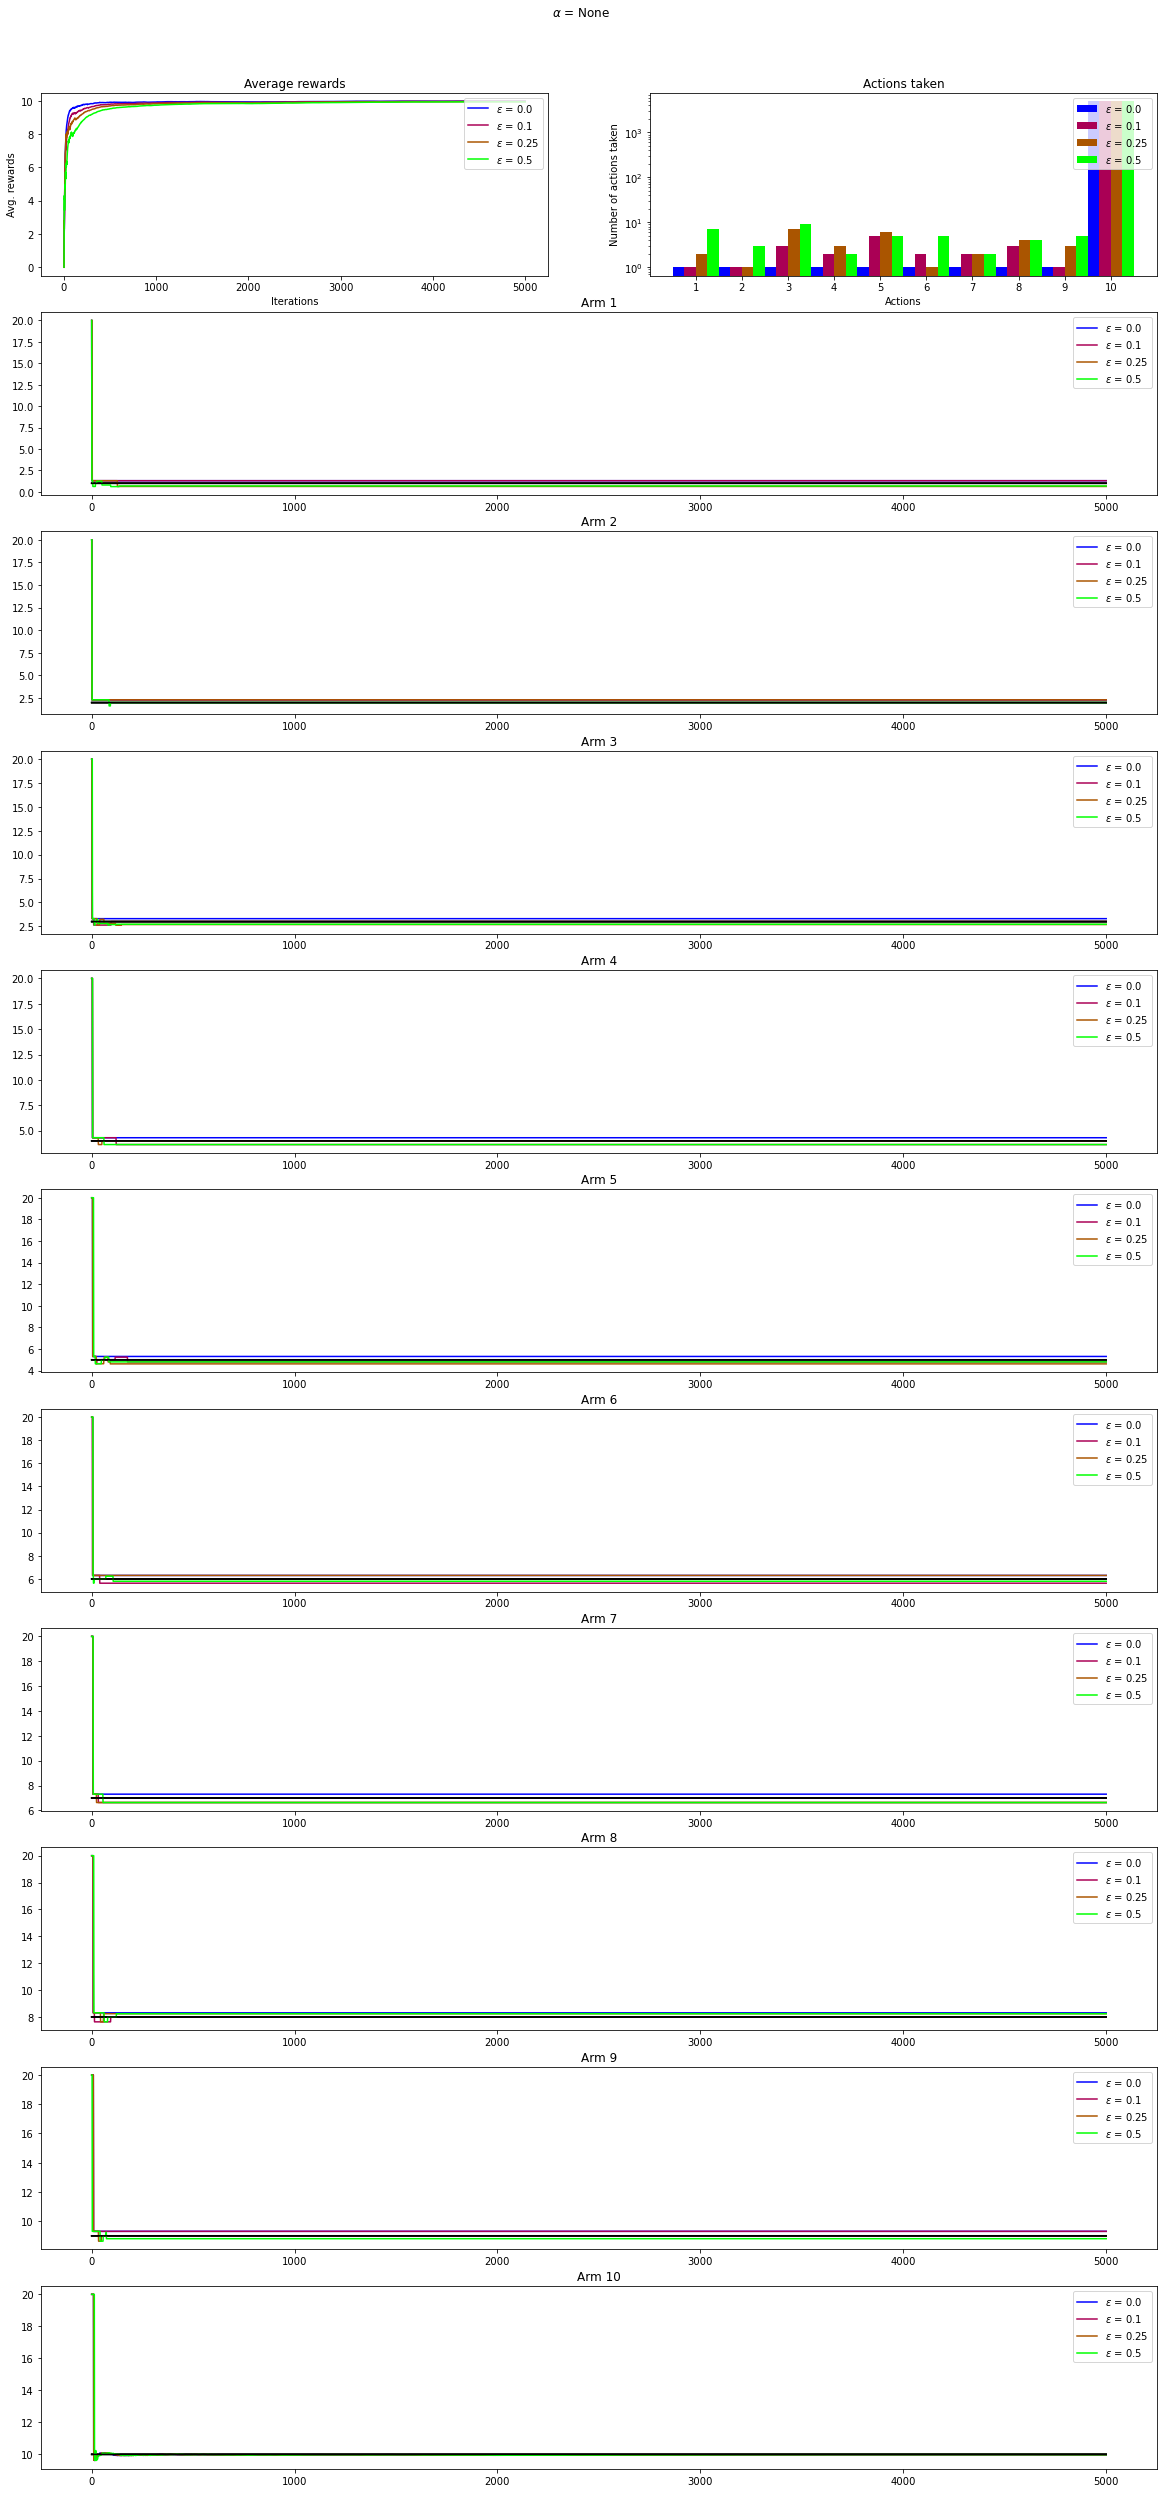

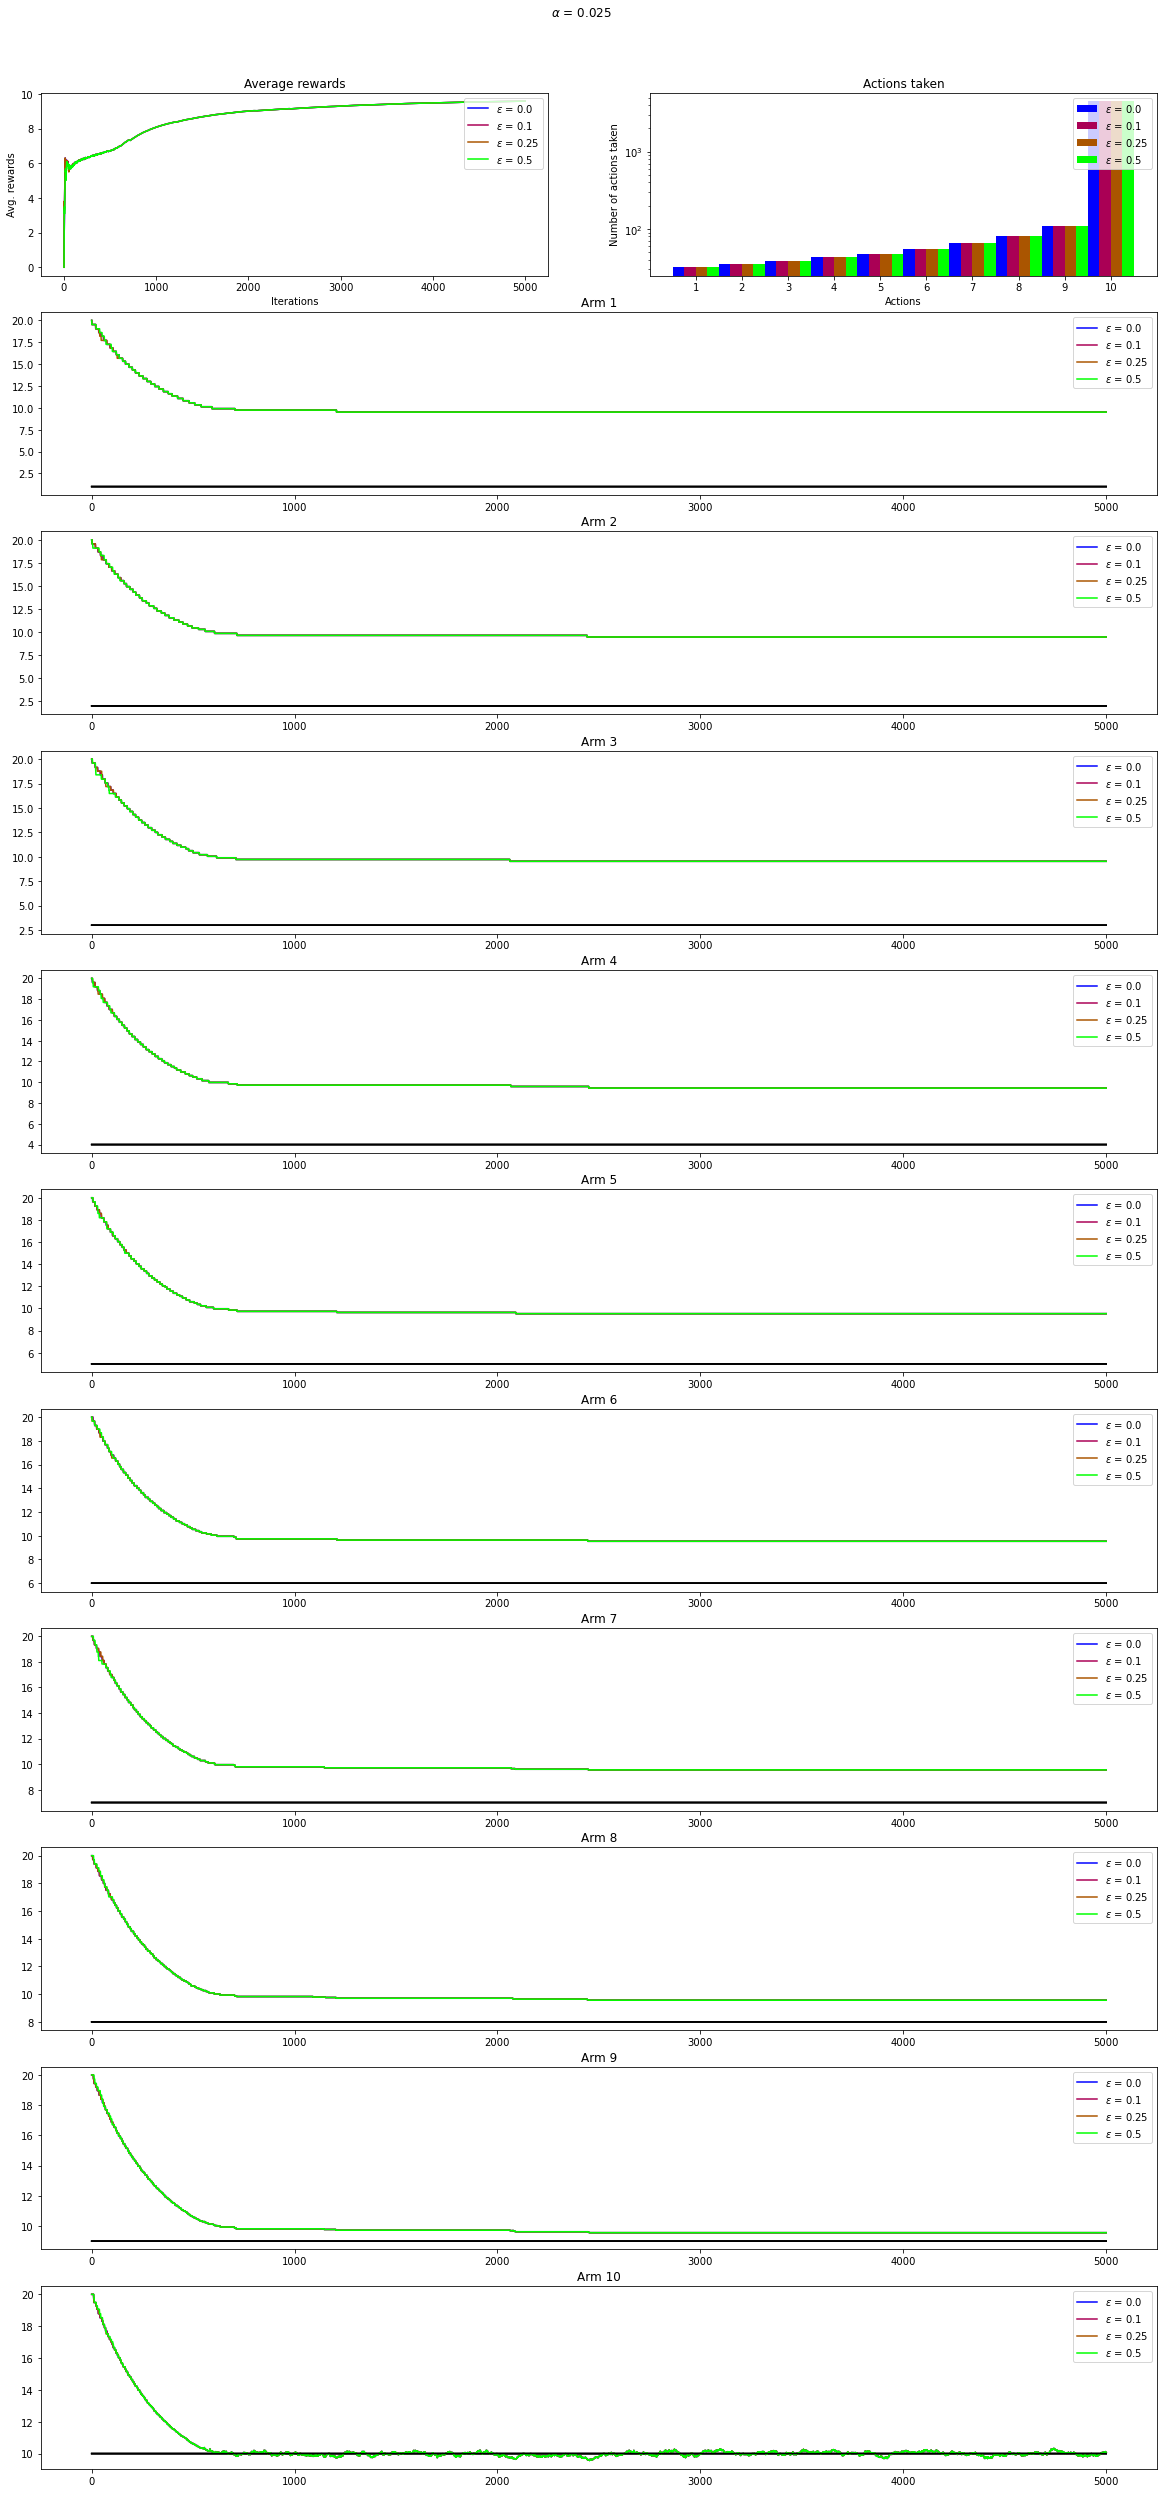

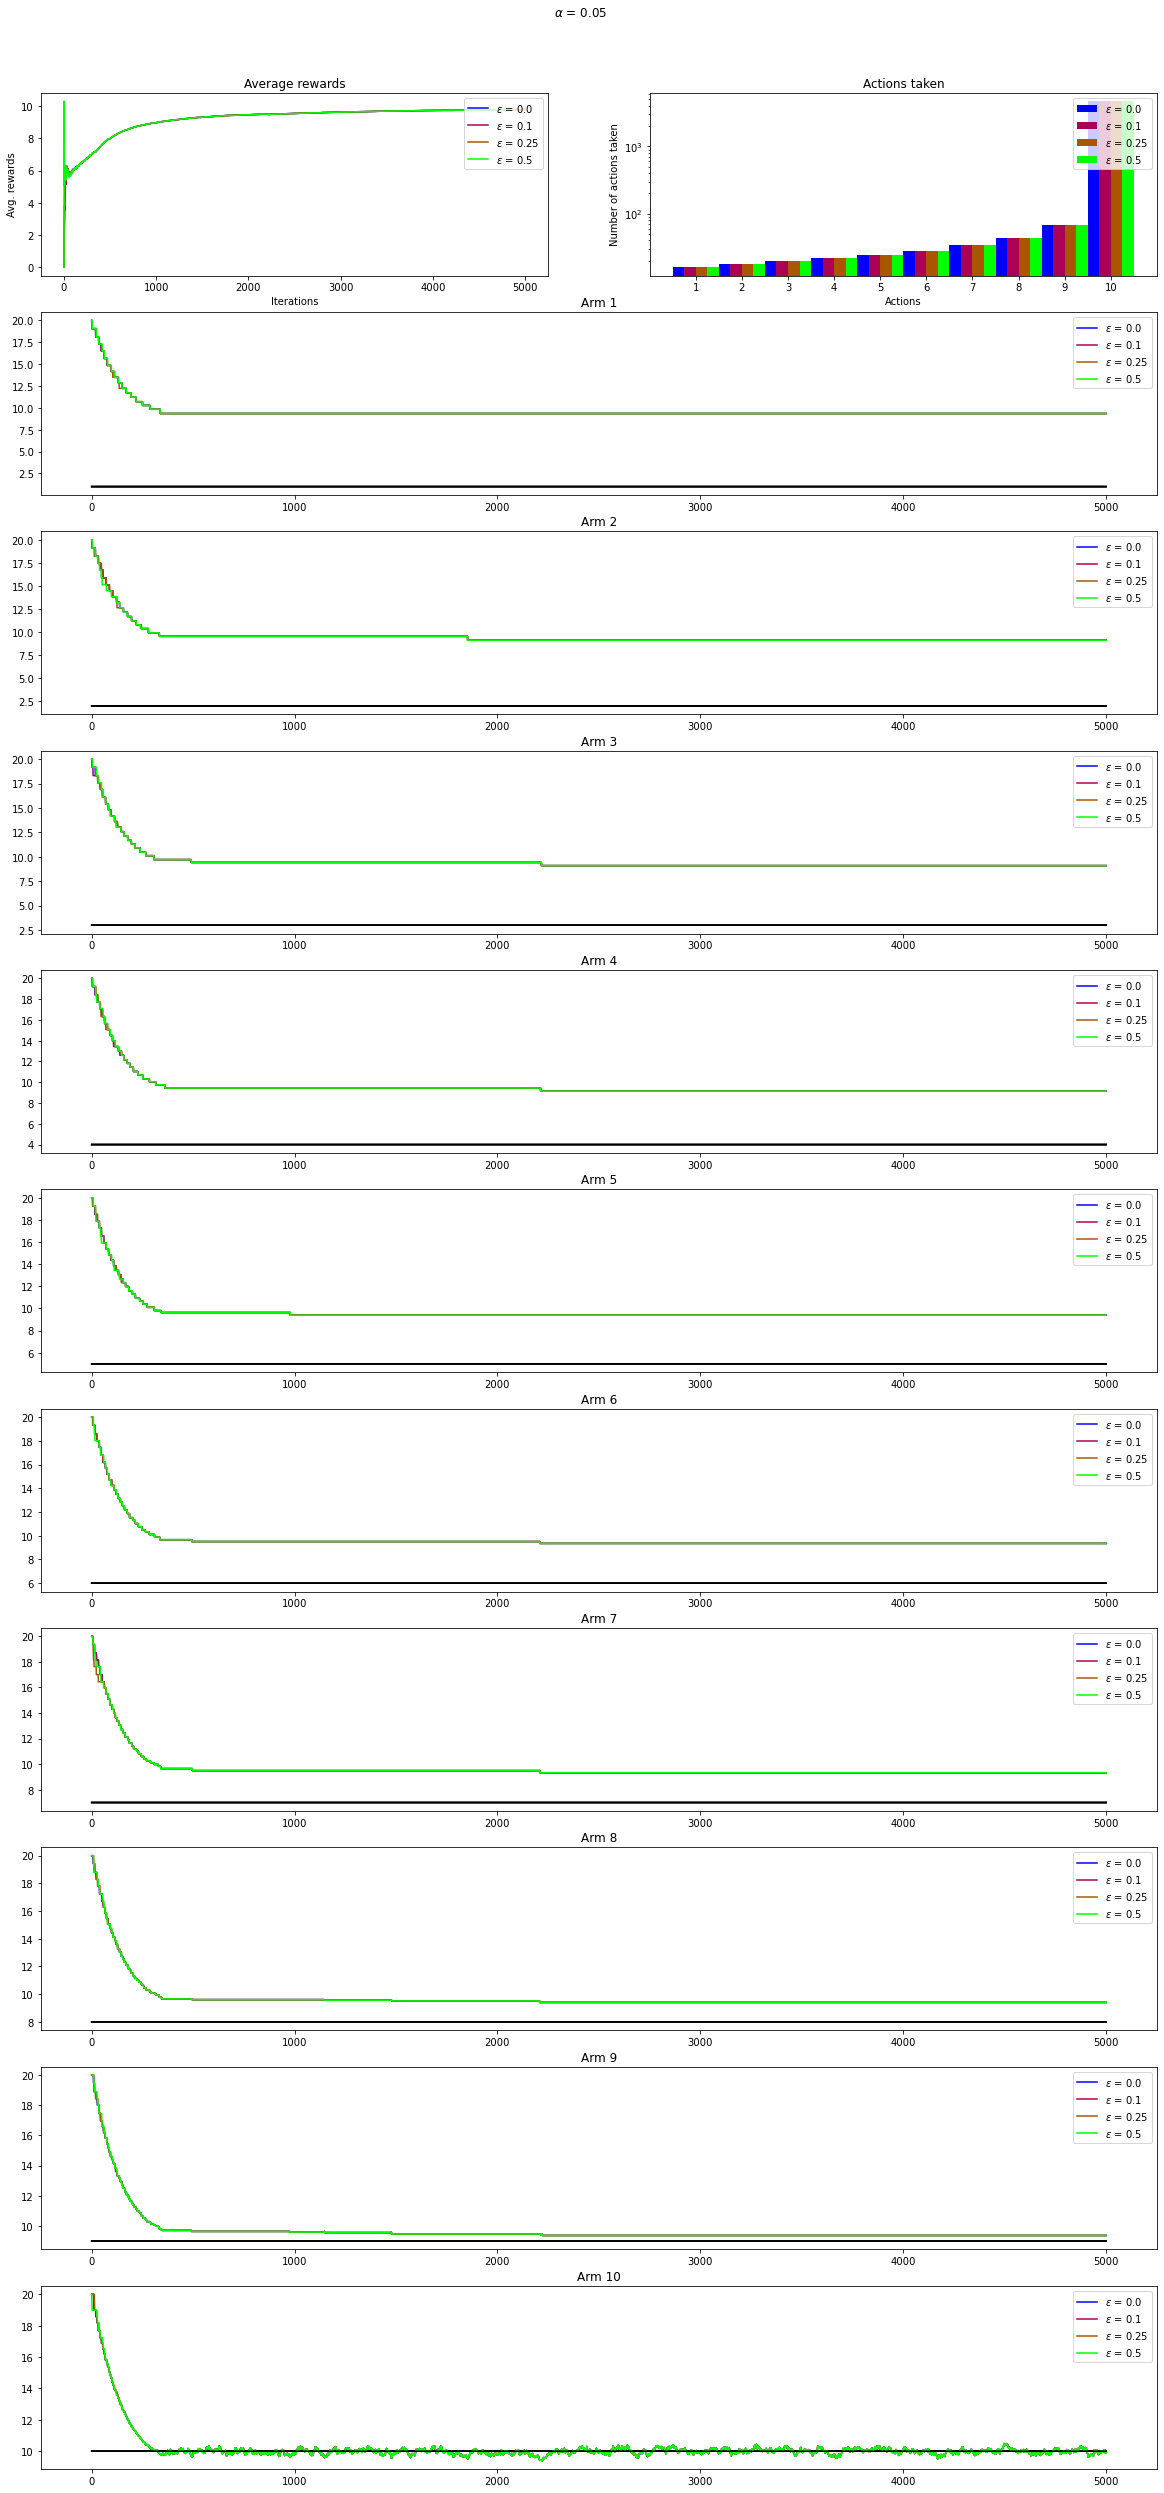

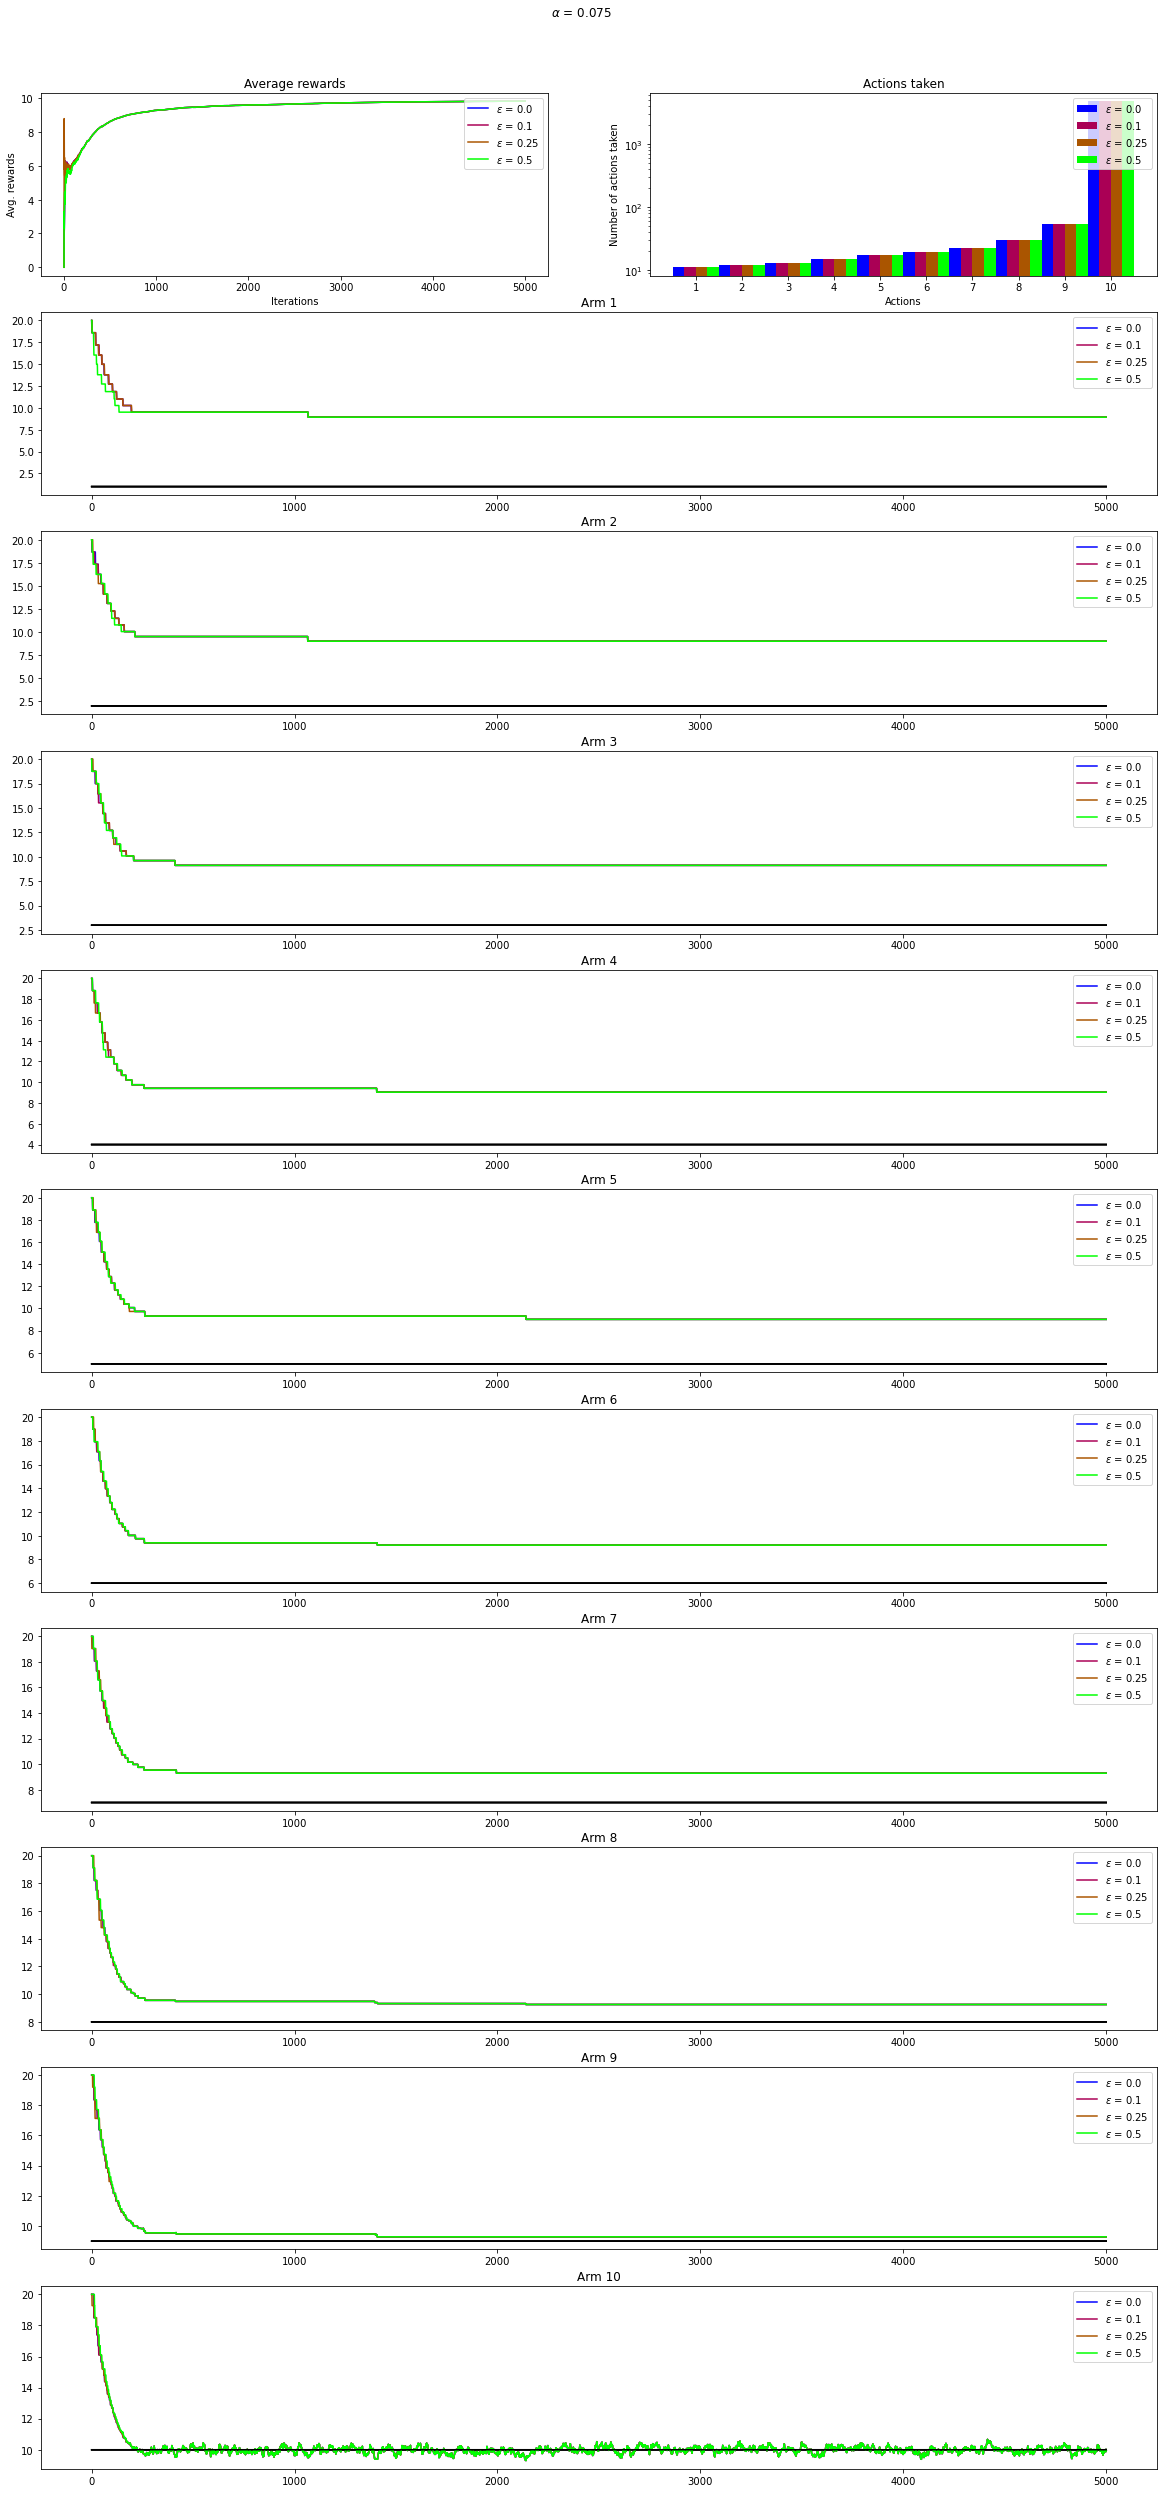

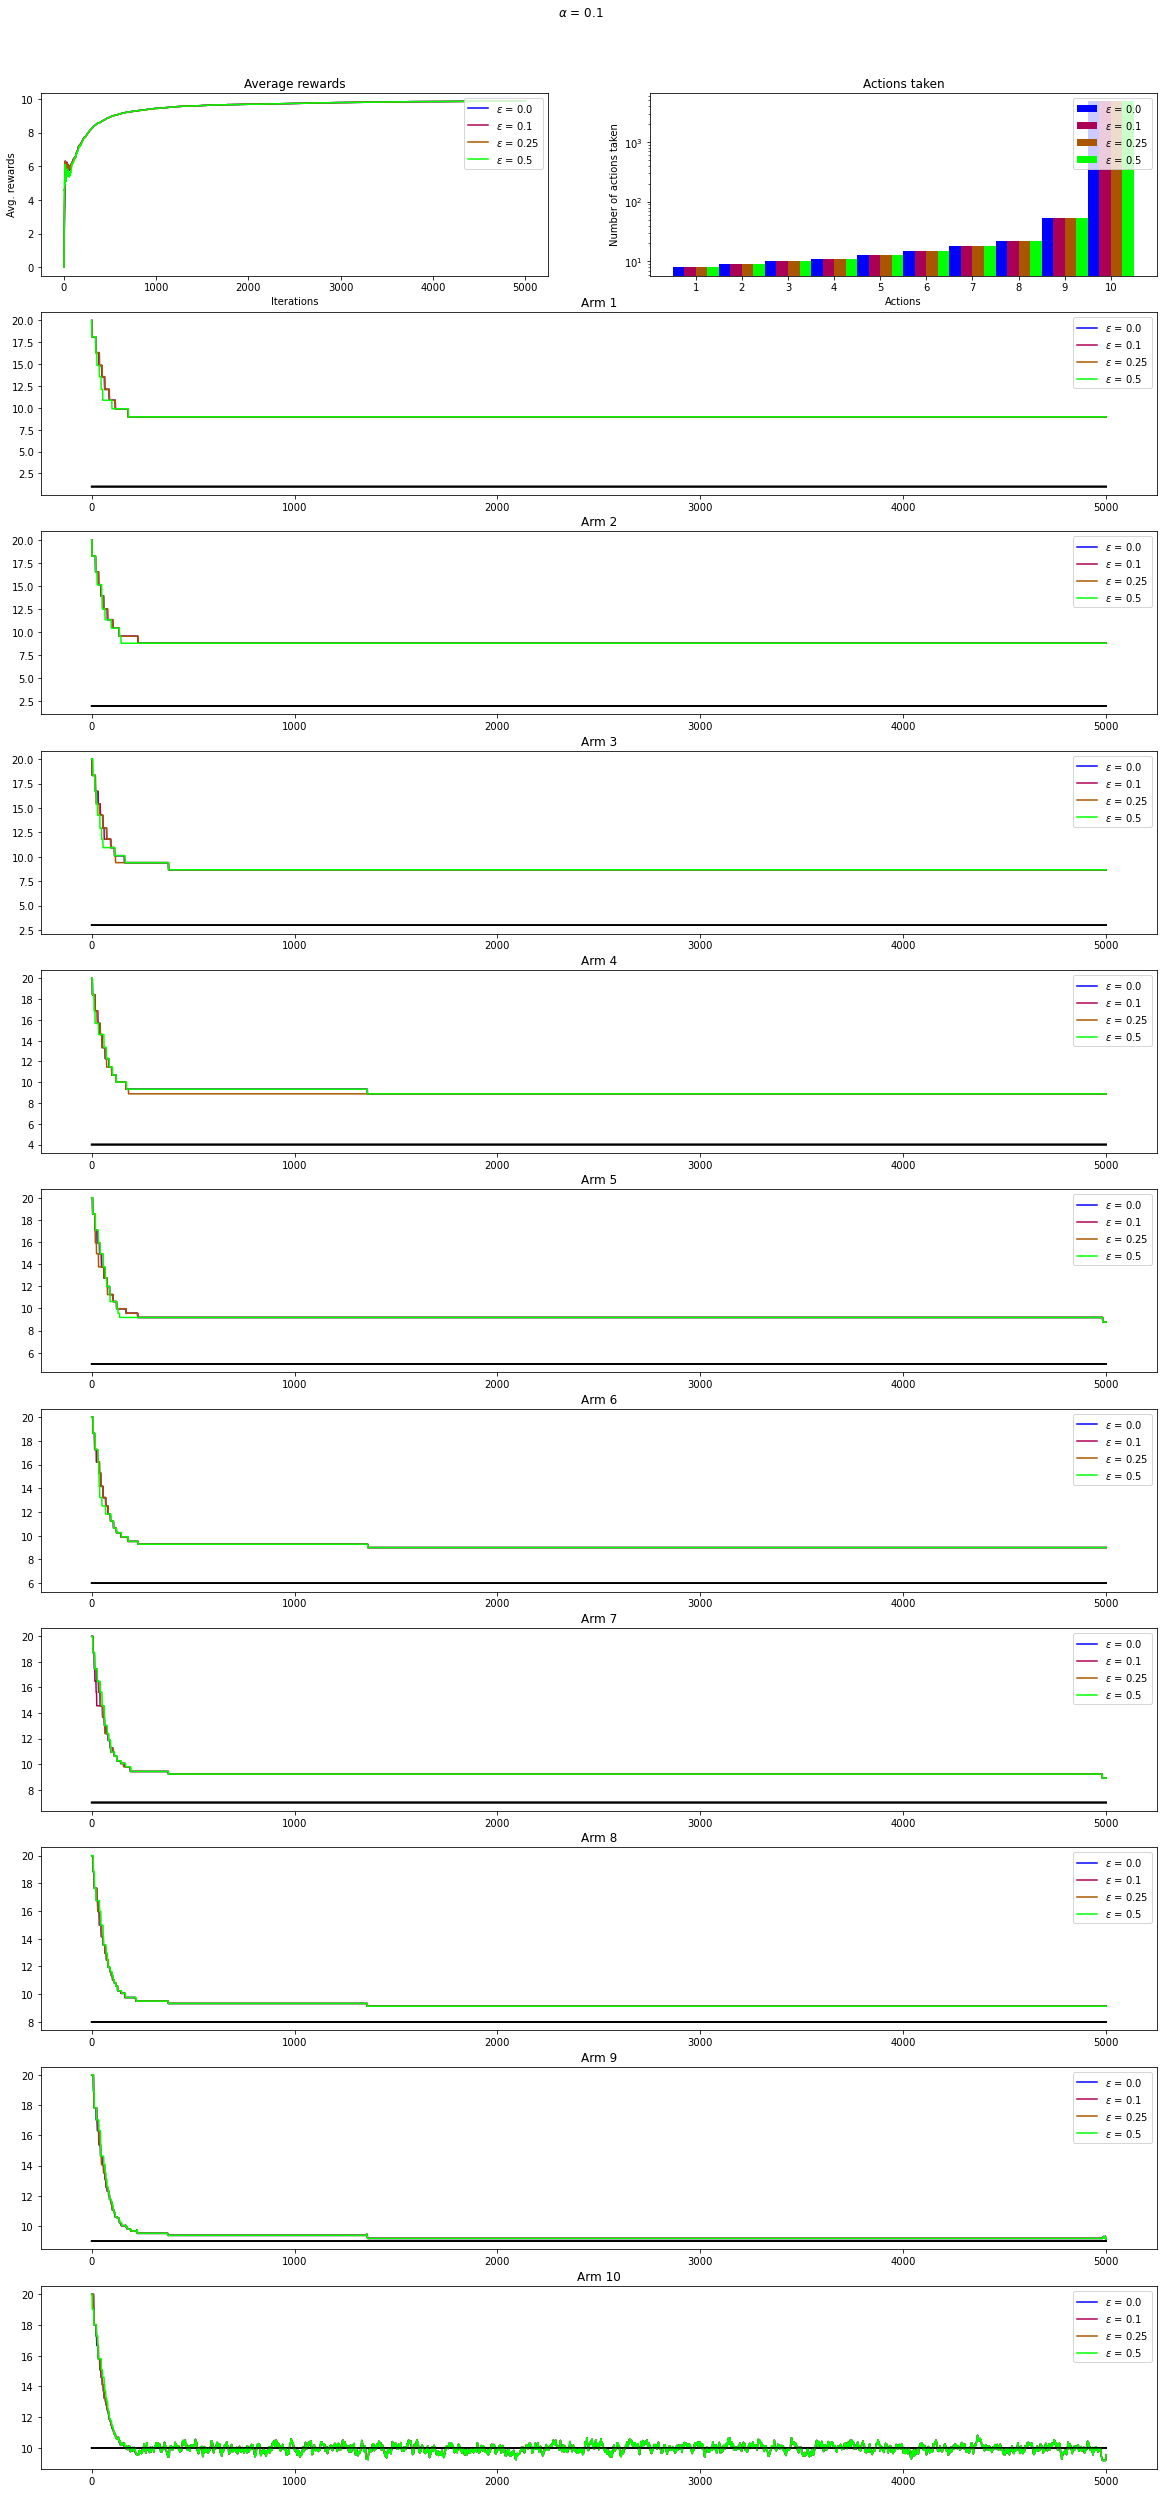

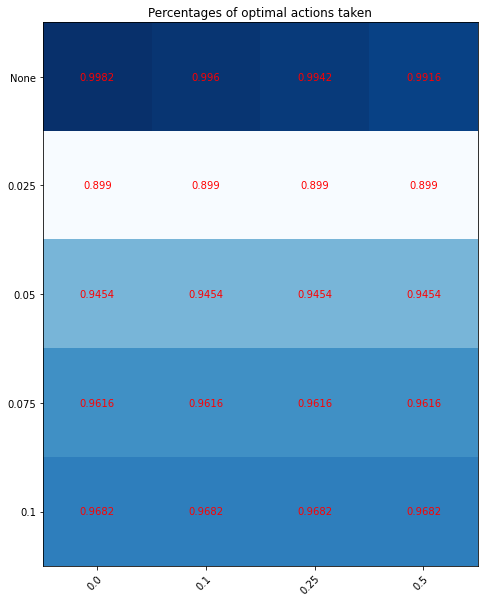

In [5]:
# Simulation parameters (some MUST be floats!).
iters = 5000
opt_init = 20.0
arms = 10
means = np.arange(1.0, float(arms + 1), 1.0)
sigmas = np.full(arms, 1.0)
alphas = [None, 0.025, 0.05, 0.075, 0.1]
epsilons = [0.0, 0.1, 0.25, 0.5]
det = False
stat = True

eps_plots(iters, opt_init, arms, means, sigmas, alphas, epsilons, det, stat)

## Stochastic, non-stationary case

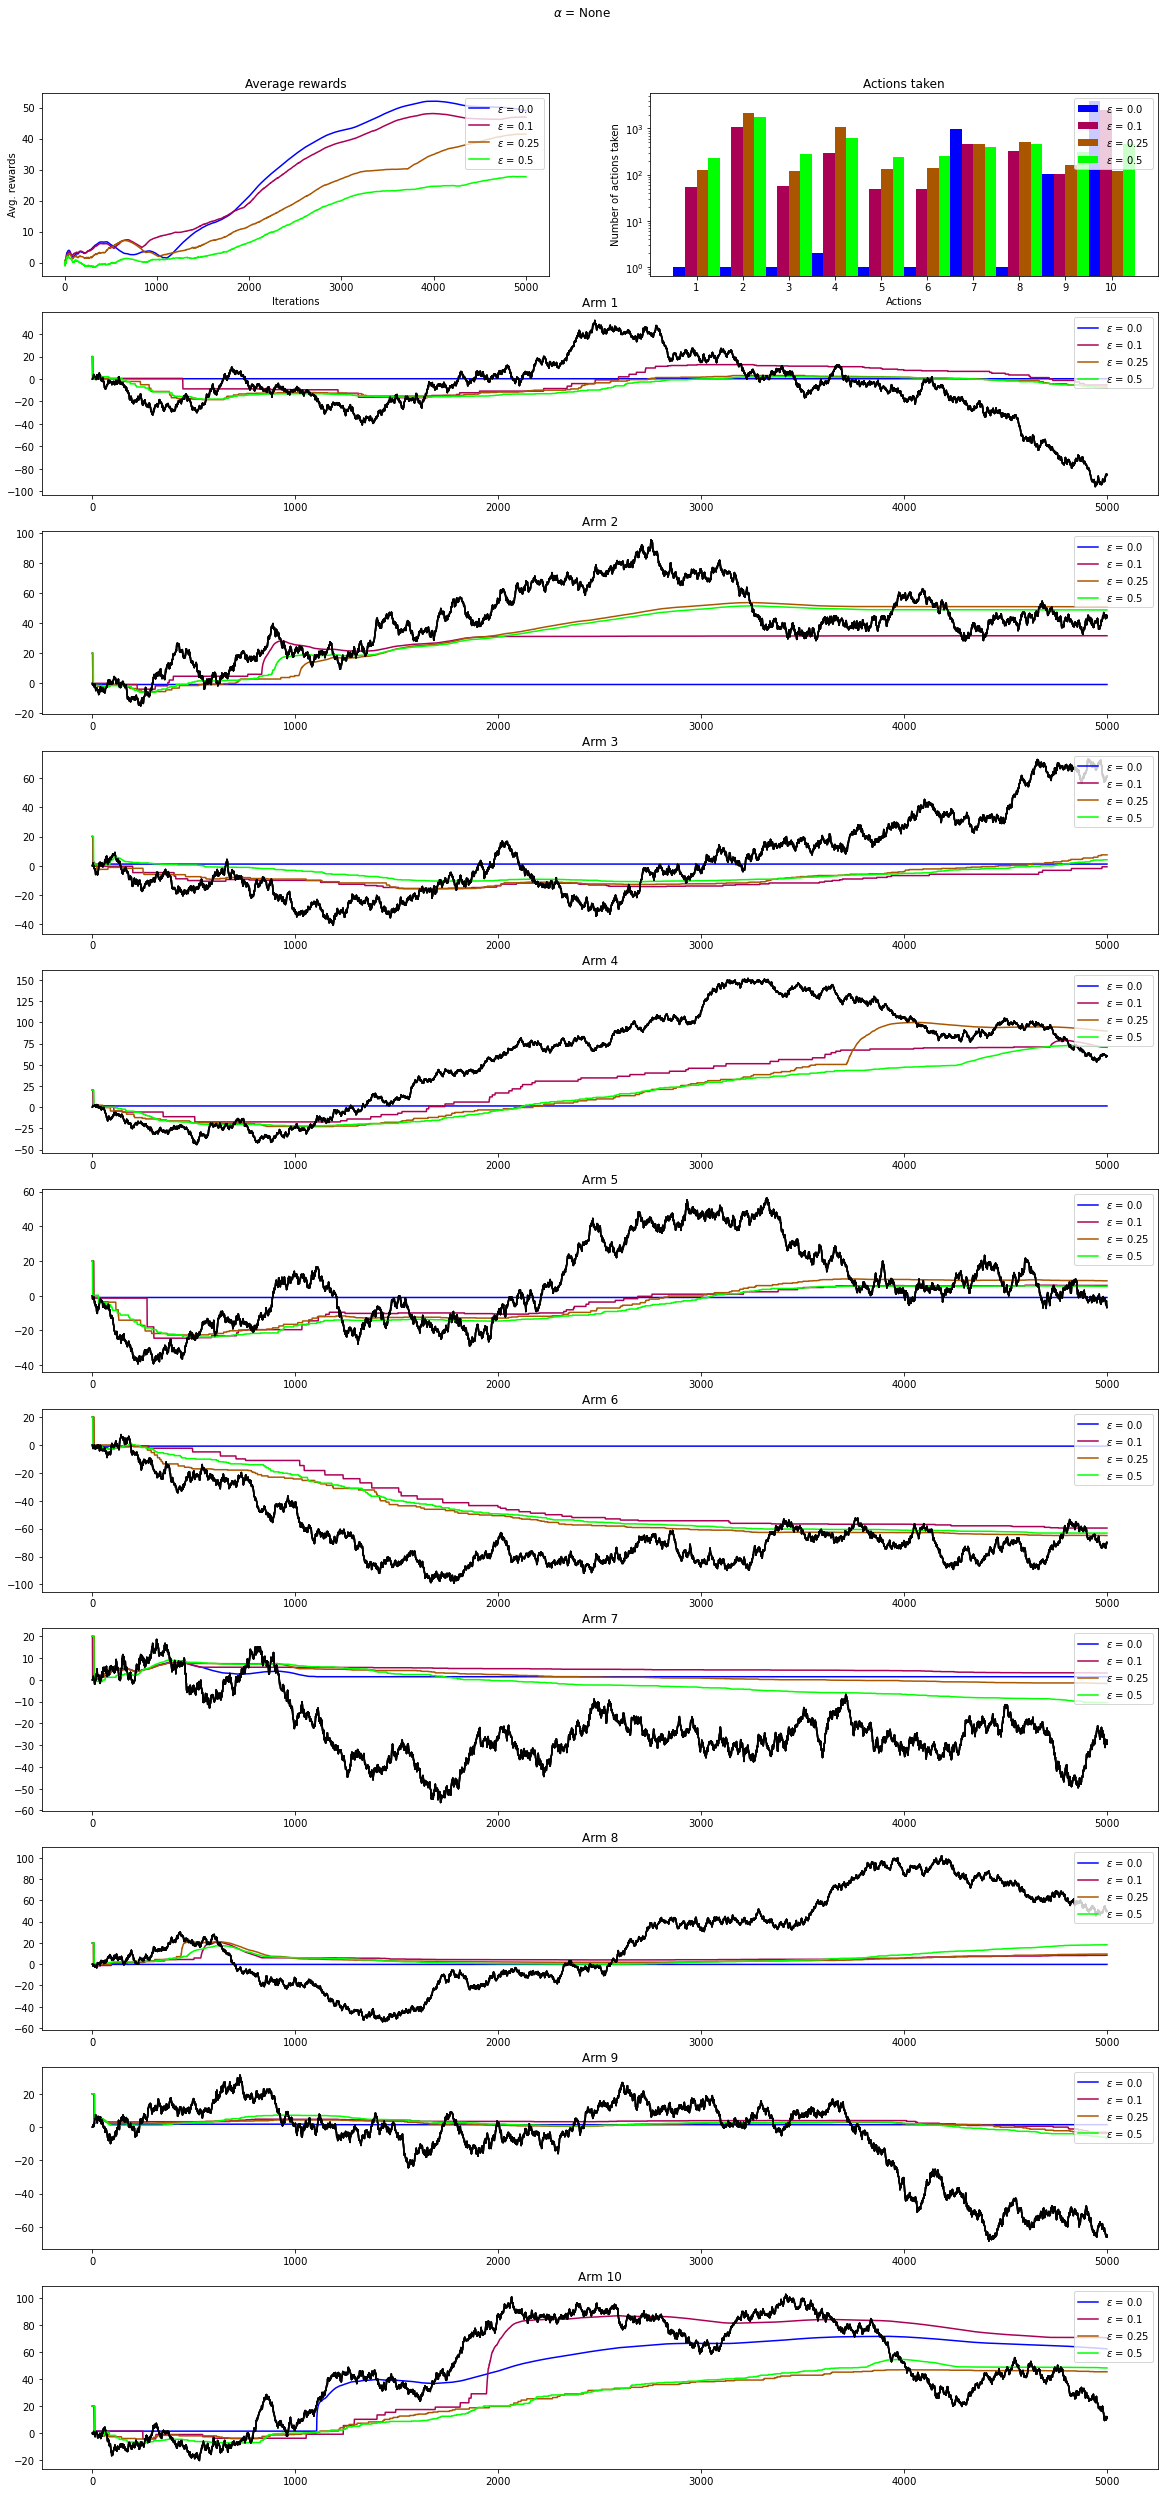

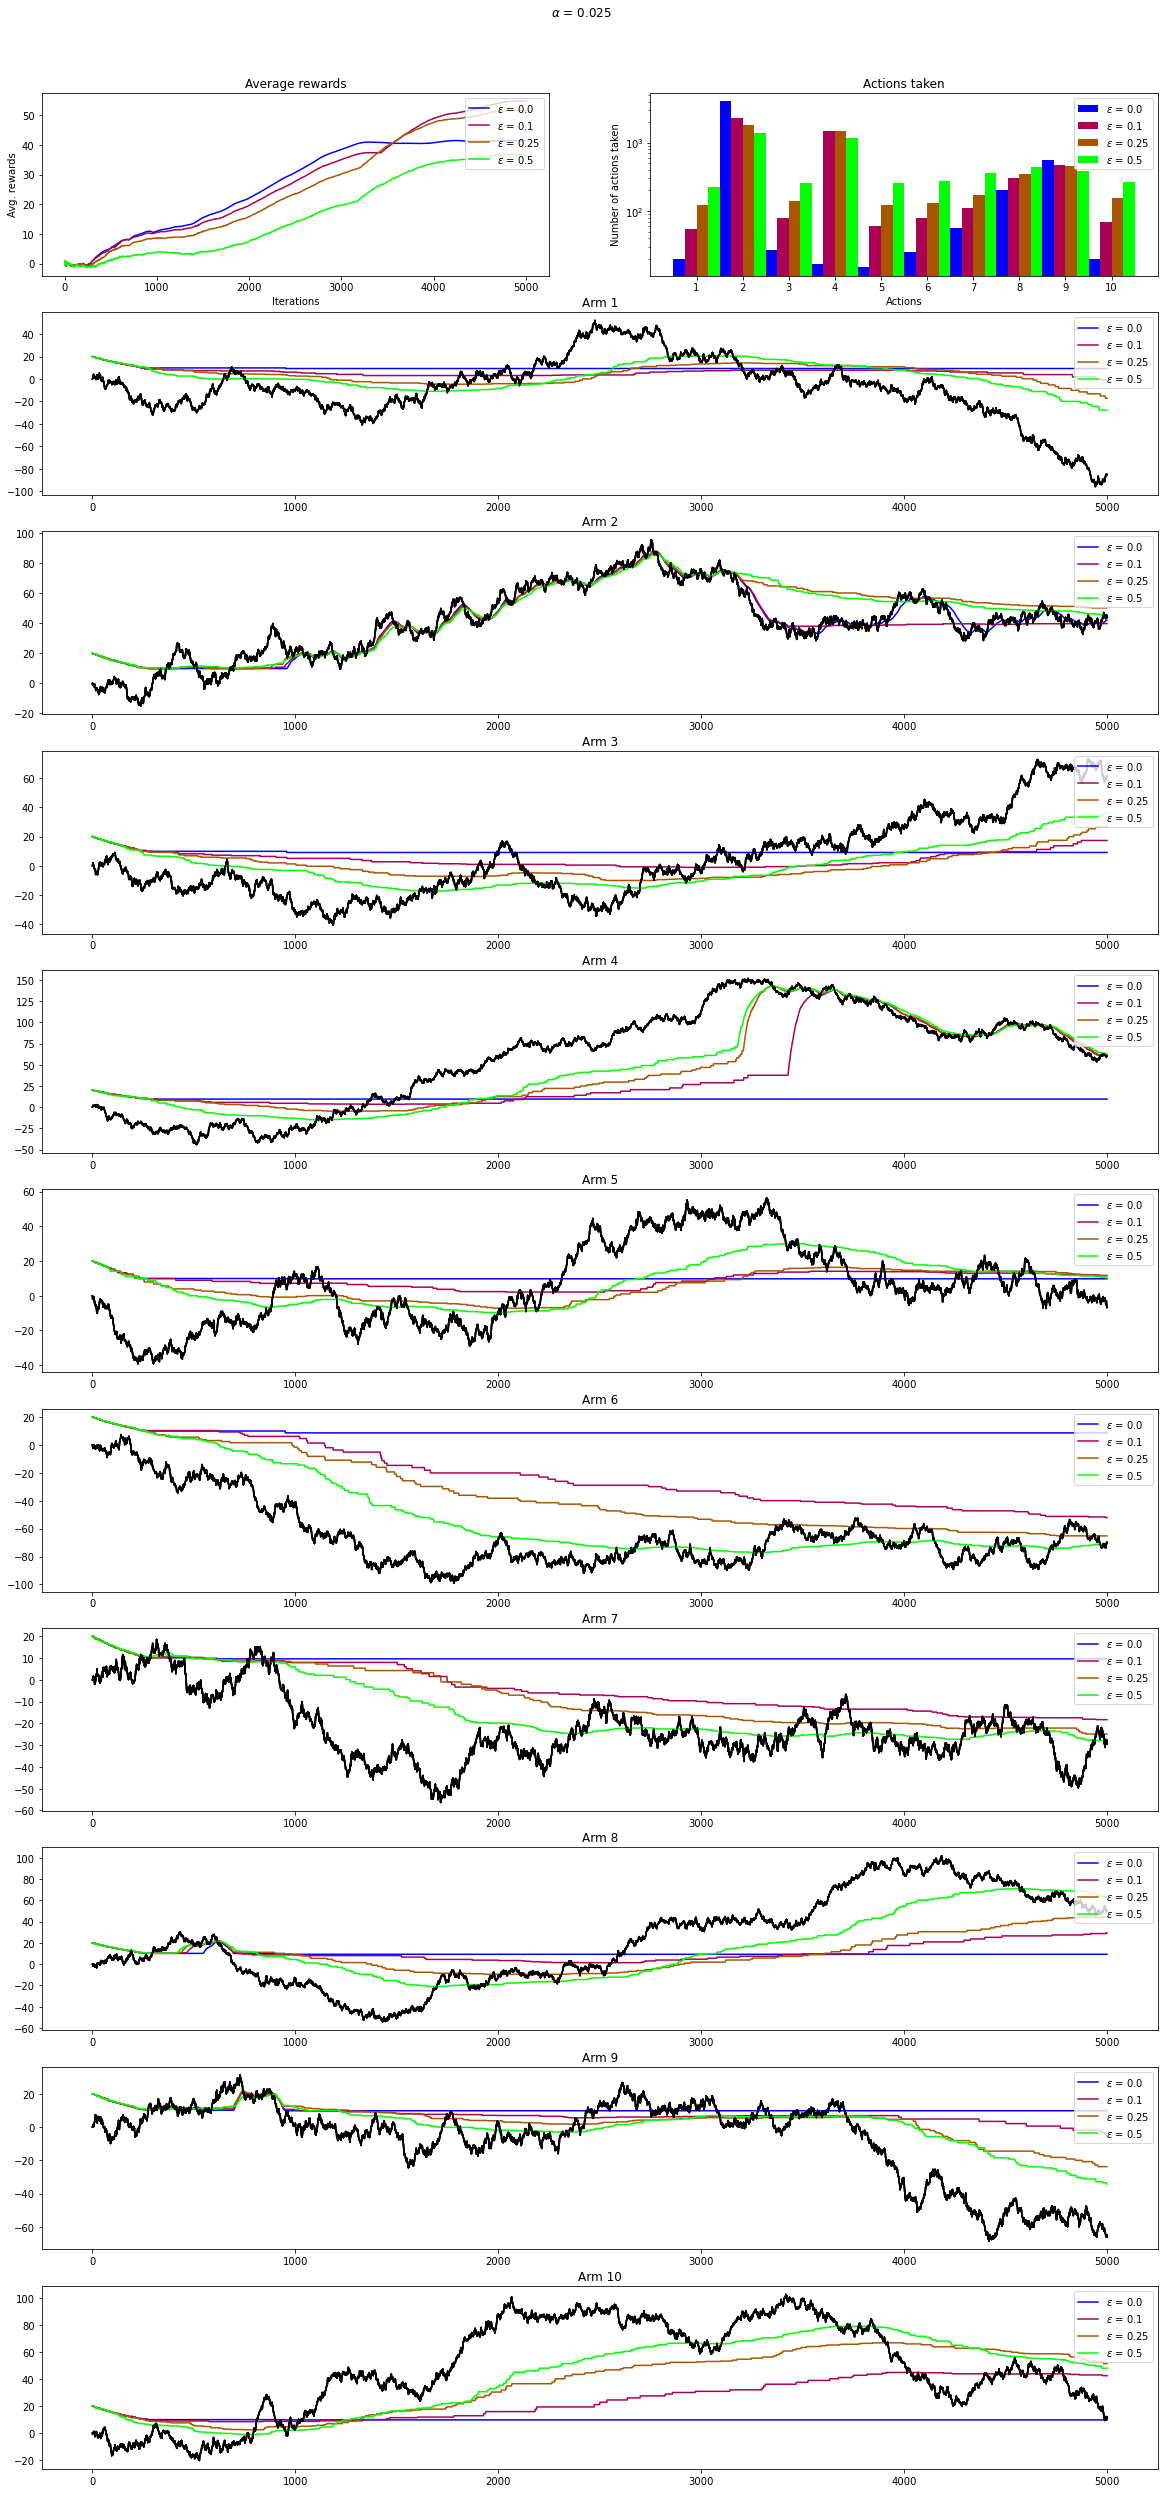

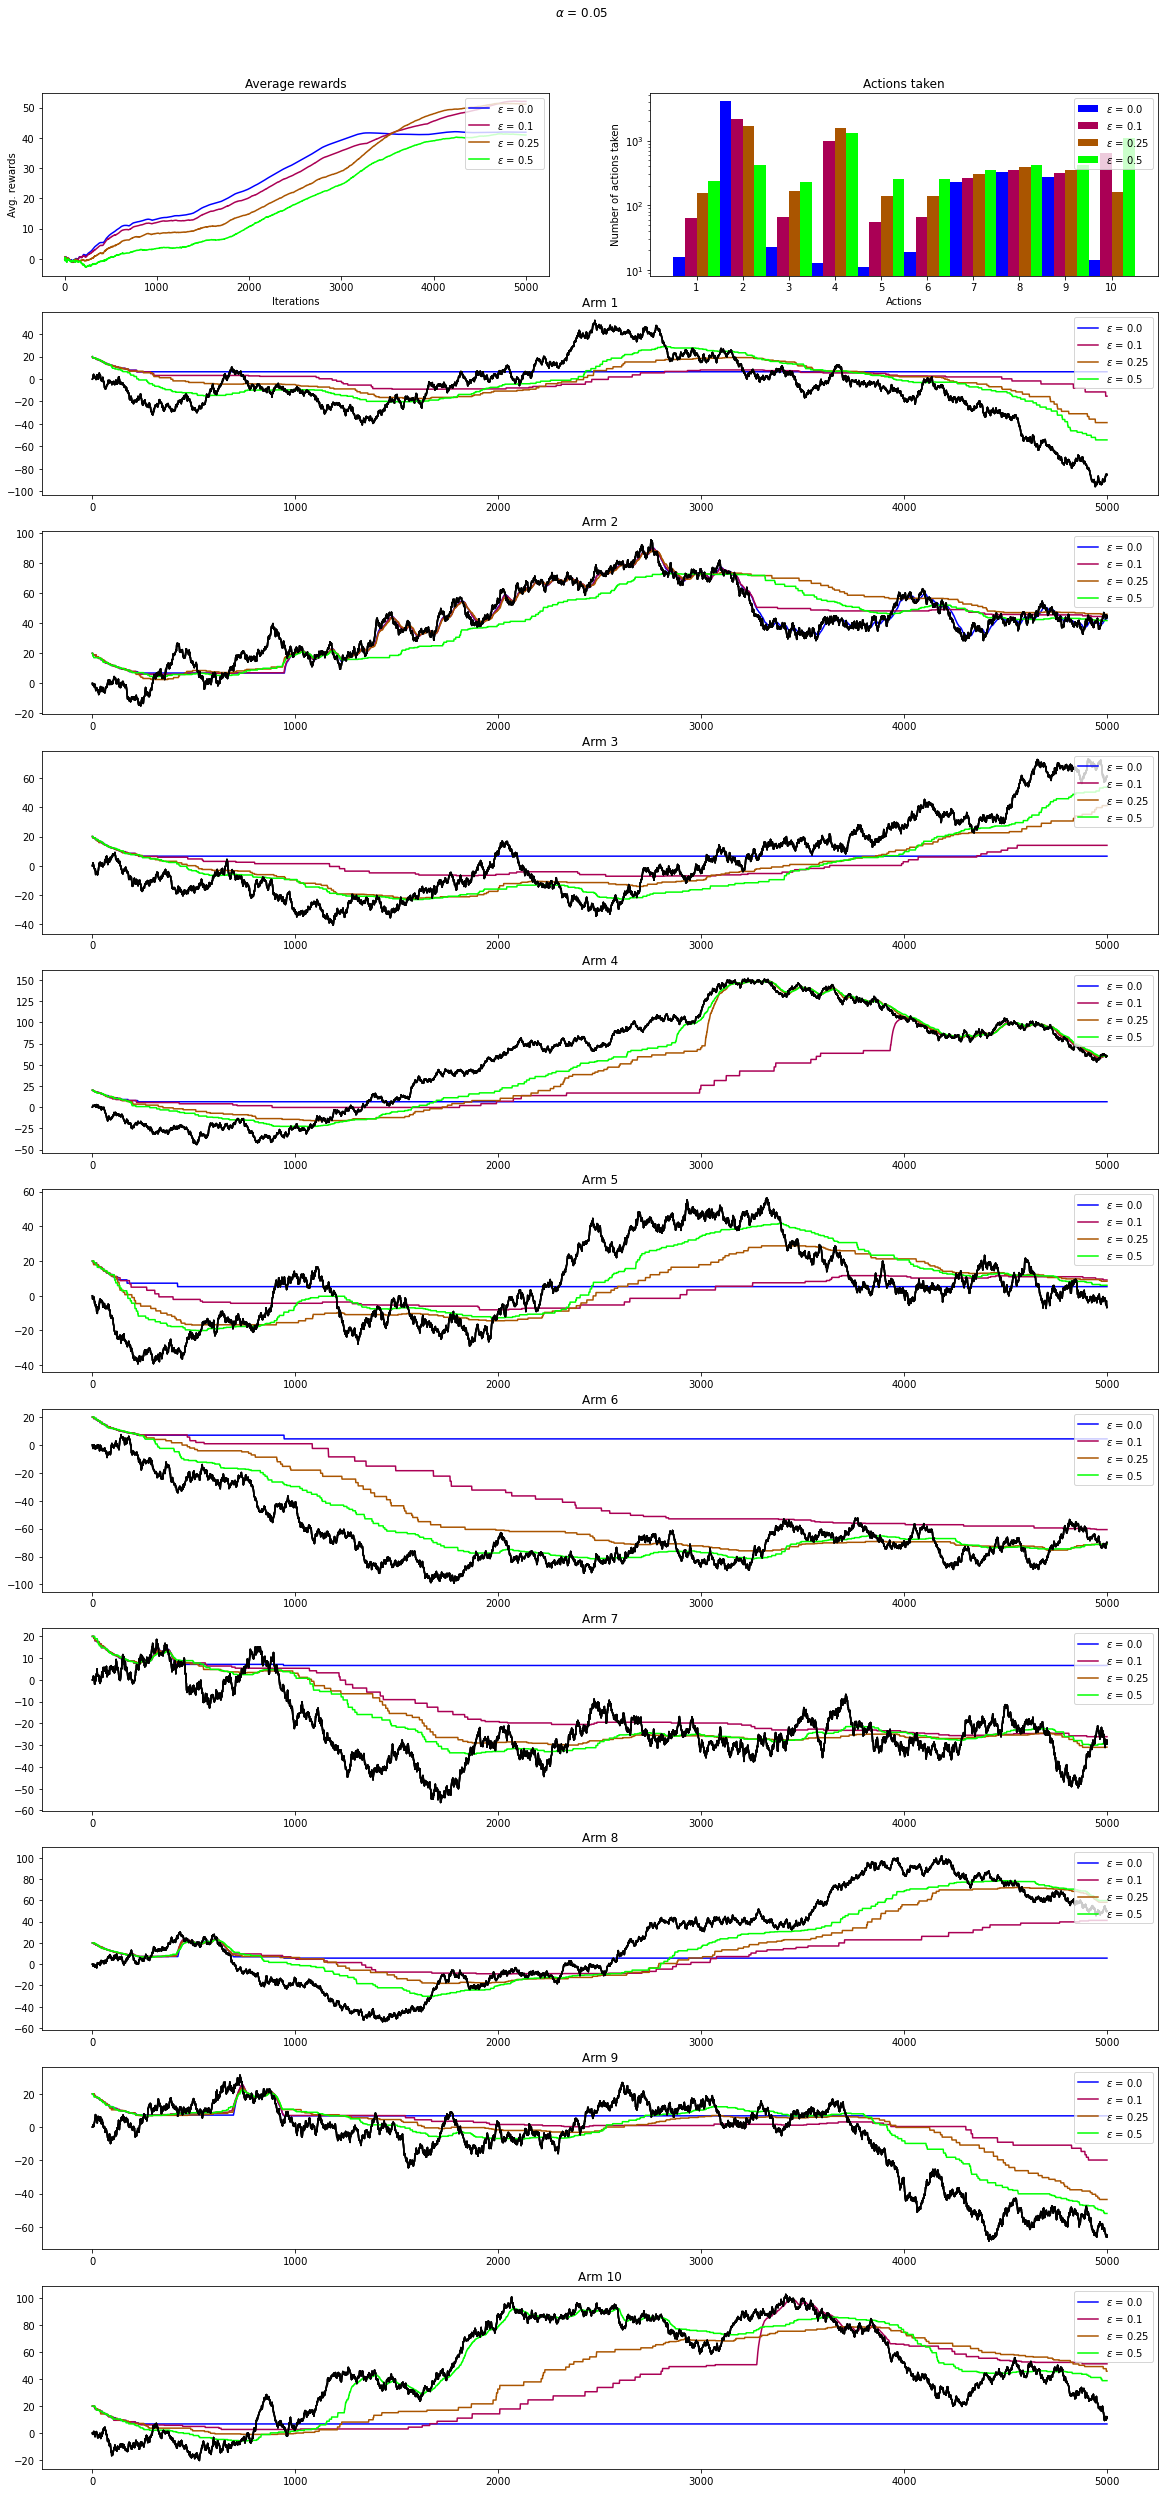

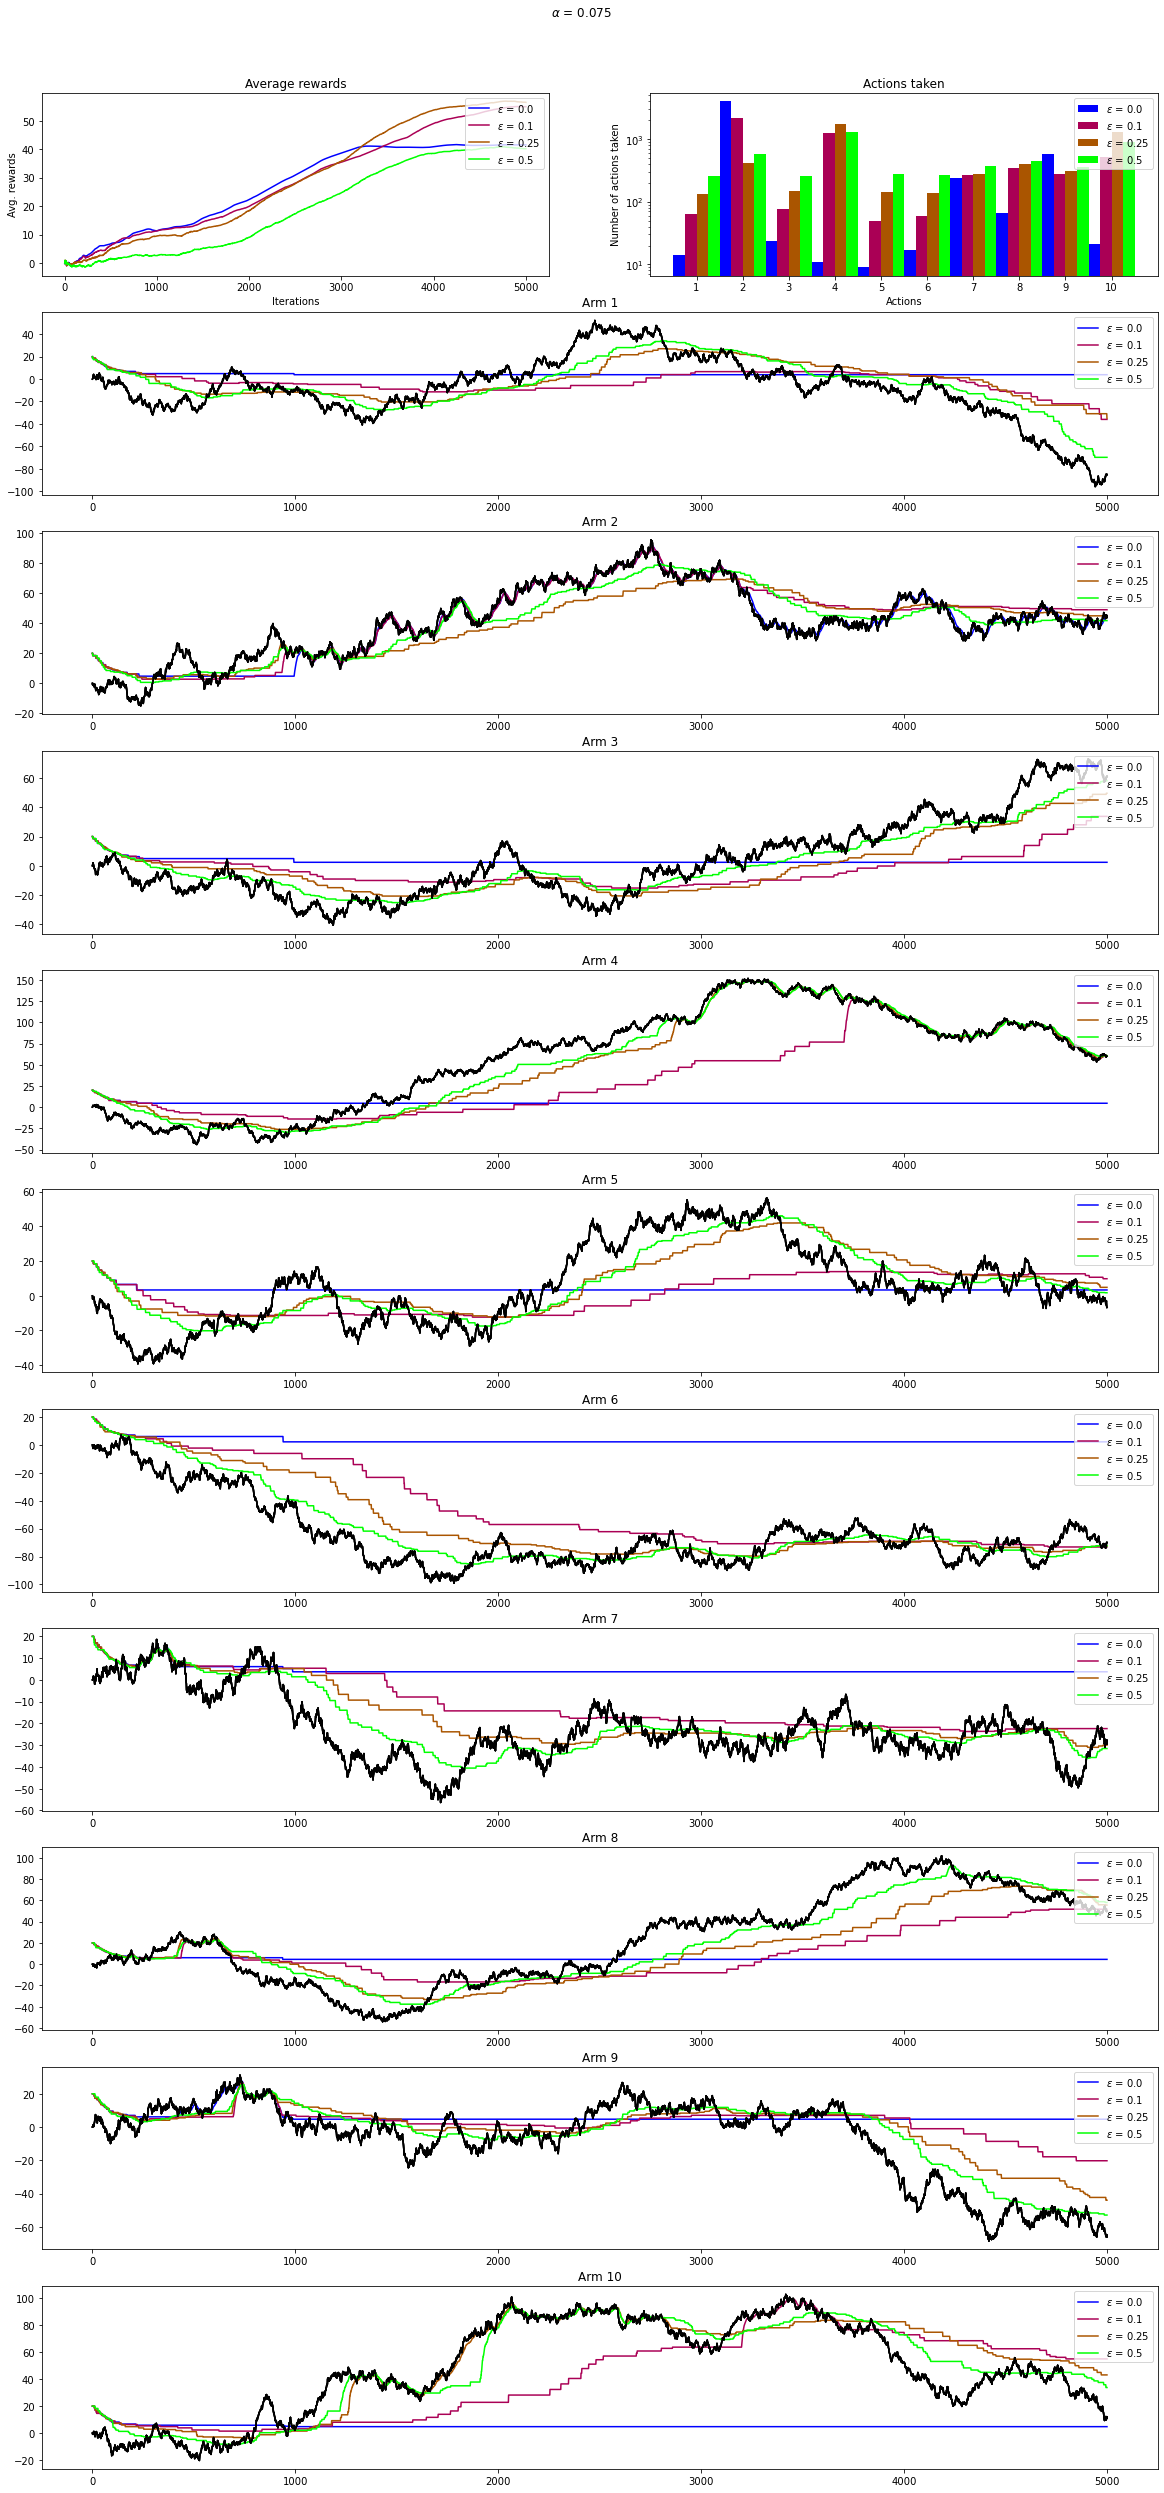

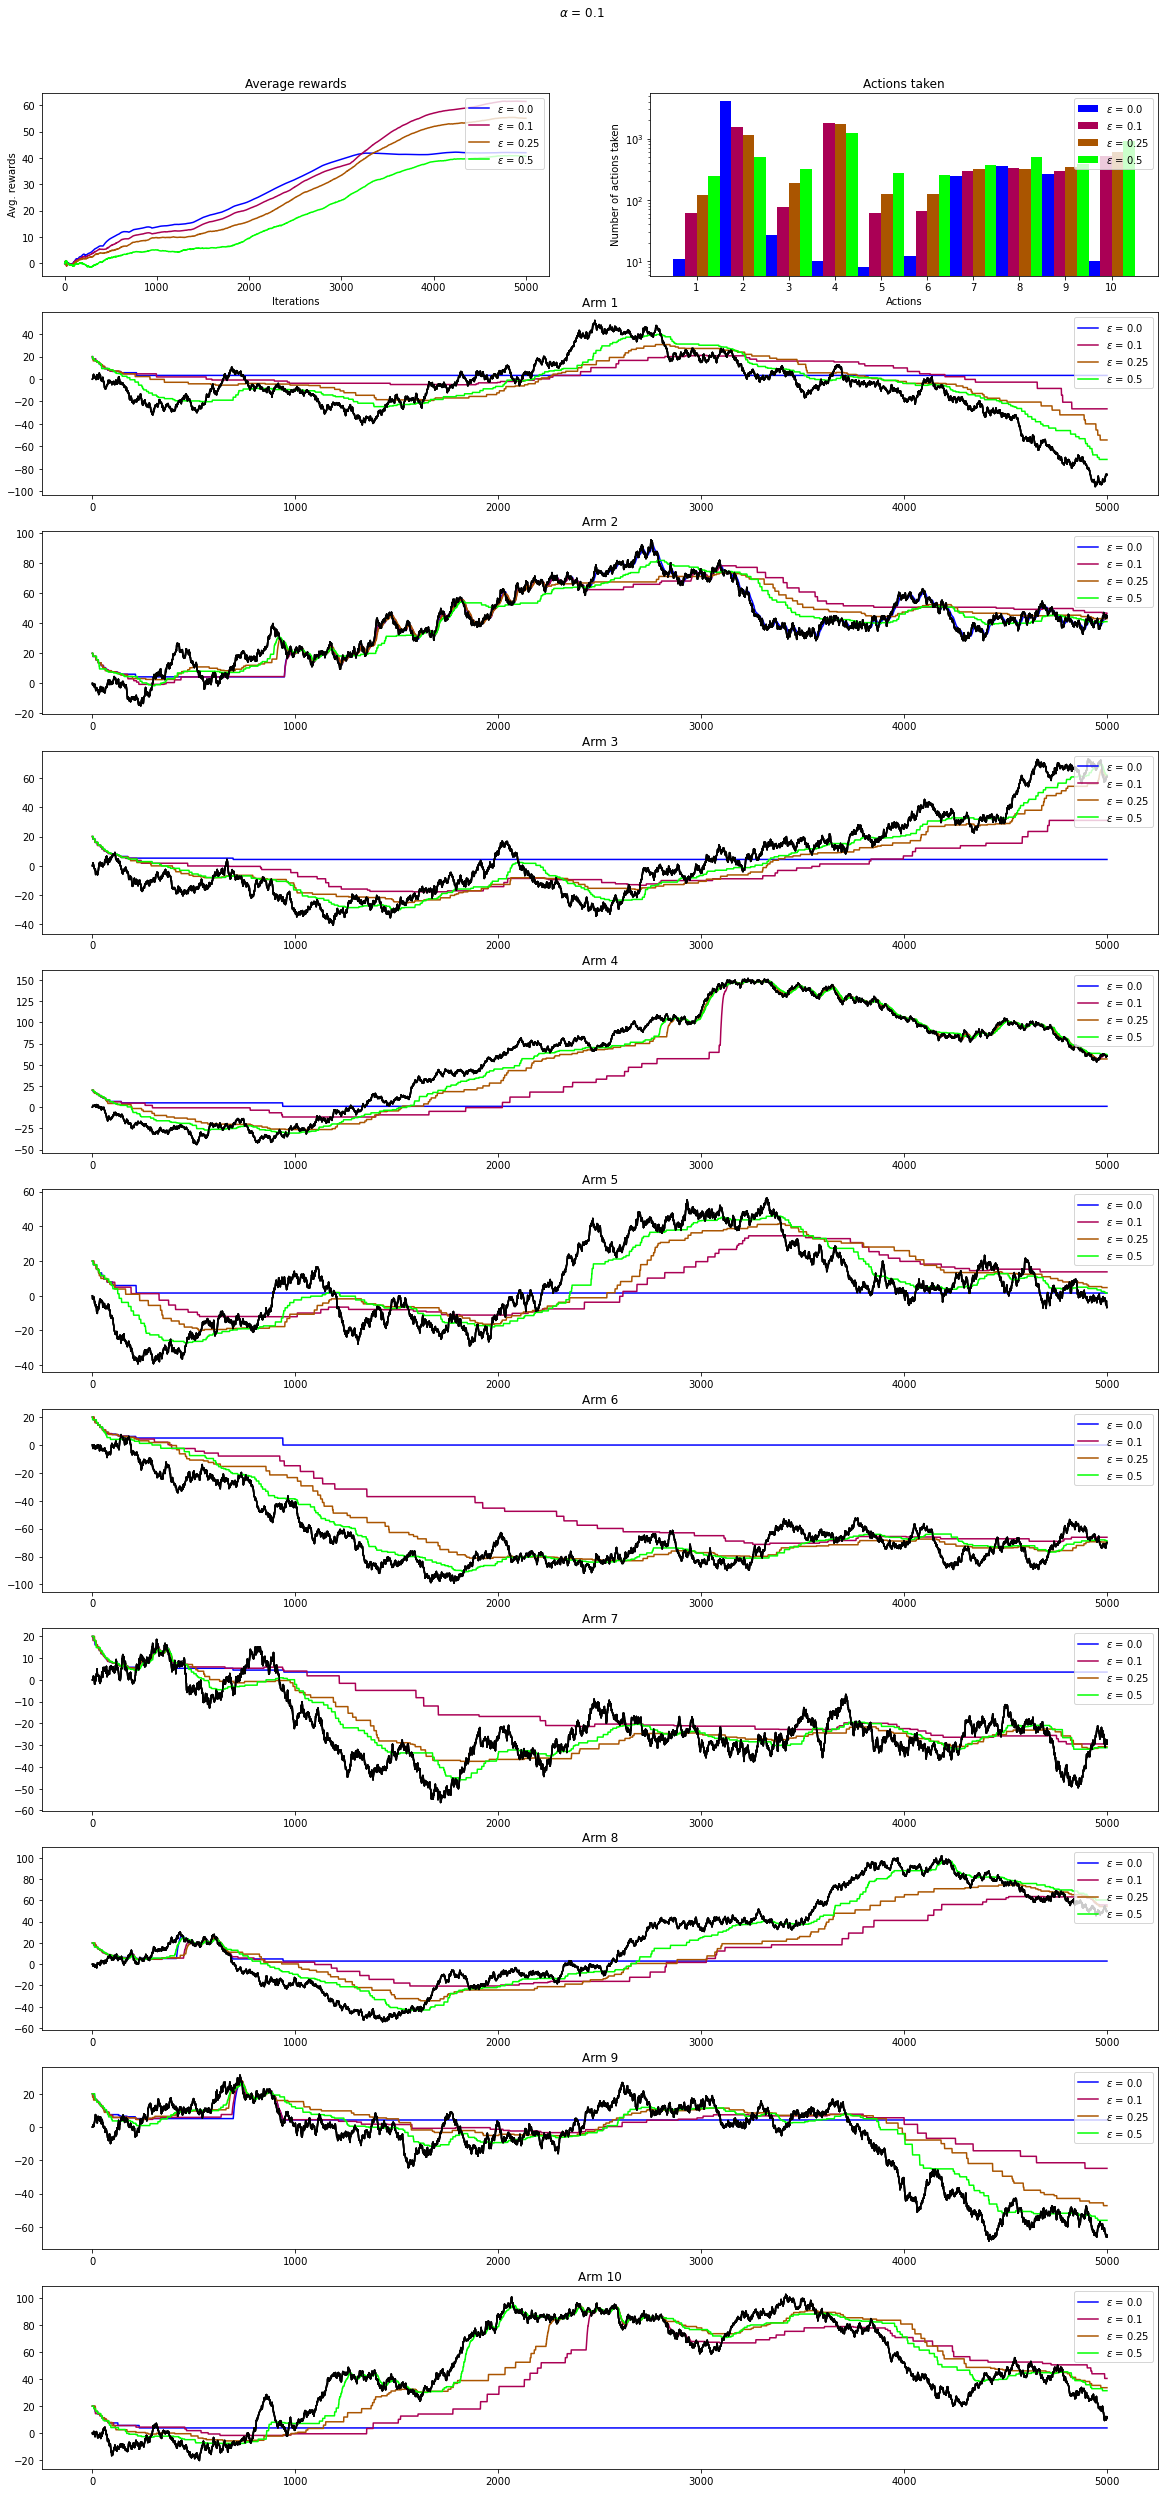

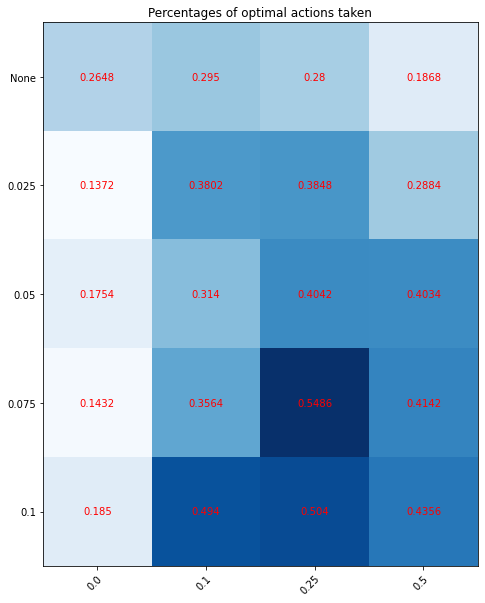

In [6]:
# Simulation parameters (some MUST be floats!).
iters = 5000
opt_init = 20.0
arms = 10
means = np.full(arms, 0.0)
sigmas = np.full(arms, 1.0)
alphas = [None, 0.025, 0.05, 0.075, 0.1]
epsilons = [0.0, 0.1, 0.25, 0.5]
det = False
stat = False

eps_plots(iters, opt_init, arms, means, sigmas, alphas, epsilons, det, stat)